# aai-510-group2-final-project

# Cluster Quest - Mapping Social Cohorts in Facebook Networks

## Team Members:

Alejandro Marchini

Carlos Alberto Ortiz Montes De Oca

Swathi Subramanyam Pabbathi

## ** PROBLEM STATEMENT **

In the ever-expanding digital ecosystem, social networking platforms host millions of users interacting through friendships, communities, and shared content. Despite the abundance of data, most platforms rely on surface-level metrics such as follower count, likes, or activity frequency to understand their user base. These traditional metrics fail to capture the underlying structure and behavioral dynamics of the social graph — which are crucial for strategic decisions.

This limited understanding leads to several core challenges:

> Ineffective Ad Targeting: Without knowing how users are grouped or interconnected, advertisers can’t accurately identify niche segments or key influencers, leading to wasted spend and poor engagement.

> Generic Recommendations: Recommendation systems lack the granularity to personalize content, connections, or group suggestions. Users often receive suggestions that are irrelevant or too broad, impacting platform engagement and satisfaction.

> Community Health Blind Spots: Platforms struggle to identify isolated users, influential subgroups, or toxic clusters, which limits their ability to promote healthy discourse and retain users.

As the user base scales and behaviors diversify, these challenges become even more pronounced, requiring a more structural and behavioral approach to user segmentation.

This project addresses the above challenges by applying clustering algorithms to a real-world social graph (e.g., Facebook Combined dataset). By extracting and clustering users based on centrality, local density, community embedding, and connectivity, we move beyond vanity metrics and deliver interpretable, actionable user segmentation for marketing, design, and product innovation teams.

In [1]:
#pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import all necessary libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from math import log
import networkx as nx
from igraph import Graph, plot
import igraph as ig
from math import log
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering


In [3]:
nx_graph = nx.read_edgelist('facebook_combined.txt', create_using = nx.Graph(), nodetype = int)


igraph_fb = Graph.Read_Edgelist('facebook_combined.txt', directed=False)

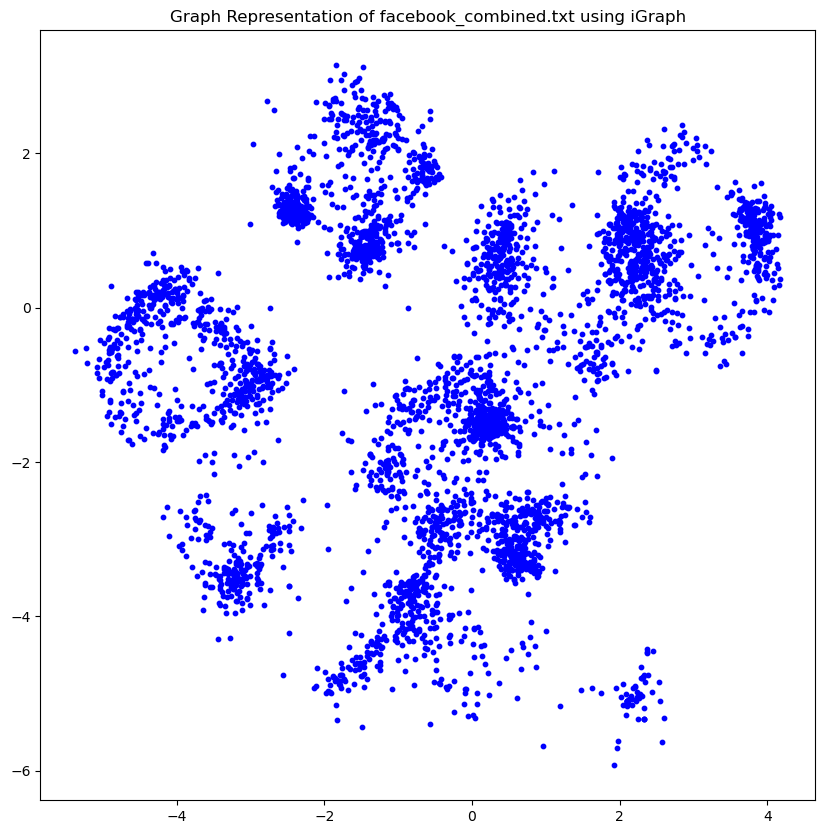

In [4]:
# Plot the graph layout
layout = igraph_fb.layout("fr")  # Fruchterman-Reingold force-directed algorithm layout

# Get node coordinates
node_positions = [(layout[x][0], layout[x][1]) for x in range(len(layout))]

# Create a scatter plot using Matplotlib
plt.figure(figsize=(10, 10))
plt.scatter(*zip(*node_positions), color='blue', s=10)  # Scatter plot of node positions
plt.title('Graph Representation of facebook_combined.txt using iGraph')
plt.show()

In [5]:
# Check whether the graph is connected
is_connected = igraph_fb.is_connected()
print(f"Is the graph connected? {is_connected}")

Is the graph connected? True


In [6]:
# Find any single nodes or no nodes
num_nodes = len(igraph_fb.vs)
print(f"Number of nodes: {num_nodes}")

Number of nodes: 4039


In [7]:
# determine if are there are any self loops or self nodes and if exists remove them
igraph_fb = igraph_fb.simplify()  # Remove self-loops and multiple edges
igraph_fb = igraph_fb.subgraph([v for v in igraph_fb.vs if v.degree() > 0])  # Remove isolated nodes


In [8]:
# igraph_fb is my graph object
# Extracting global node features
degree = igraph_fb.degree()
clustering_coeff = igraph_fb.transitivity_local_undirected()
betweenness_centrality = igraph_fb.betweenness()
closeness_centrality = igraph_fb.closeness()
pagerank = igraph_fb.pagerank()
katz_centrality = igraph_fb.personalized_pagerank(damping=0.85)
hub_scores = igraph_fb.hub_score()
authority_scores = igraph_fb.authority_score()
eigenvector_centrality = igraph_fb.eigenvector_centrality()
eccentricity = igraph_fb.eccentricity()
constraint = igraph_fb.constraint()
core_number = igraph_fb.coreness()

# Initialize lists to store 2-hop local features
mean_neighbor_degree = []
local_cluster_sizes = []
local_cluster_densities = []
local_cluster_assortativities = []
average_degree_local_clusters = []
local_clustering_coeff = []
sorensen_indices = []
adamic_adar_indices = []

# Function to calculate Sorensen index between two sets
def sorensen_index(set1, set2):
    intersection = len(set1.intersection(set2))
    return 2 * intersection / (len(set1) + len(set2))

# Function to calculate Adamic-Adar index between two sets
def adamic_adar_index(set1, set2, degrees):
    common_neighbors = set1.intersection(set2)
    return sum(1 / log(degrees[neighbor]) for neighbor in common_neighbors if degrees[neighbor] > 1)

# Compute 2-hop local features
for vertex in igraph_fb.vs:
    neighbors = igraph_fb.neighborhood(vertex.index, order=2)
    subgraph = igraph_fb.subgraph(neighbors)

    mean_neighbor_degree.append(np.mean(subgraph.degree()))
    local_cluster_sizes.append(len(subgraph.vs))
    local_cluster_densities.append(subgraph.density())
    local_cluster_assortativities.append(subgraph.assortativity_degree(directed=False))
    average_degree_local_clusters.append(np.mean(subgraph.degree()))

    # Compute the local clustering coefficient for each vertex in its 2-hop subgraph
    subgraph_clustering_coeff = subgraph.transitivity_local_undirected()
    if len(subgraph_clustering_coeff) > 0:
        local_clustering_coeff.append(np.mean(subgraph_clustering_coeff))
    else:
        local_clustering_coeff.append(0)  # Append 0 if no clustering coefficient is available

    # Compute Sorensen index for each vertex in its 2-hop subgraph
    sorensen_values = []
    adamic_adar_values = []
    for neighbor in neighbors:
        if vertex.index != neighbor:
            v_neighbors = set(igraph_fb.neighborhood(vertex.index))
            n_neighbors = set(igraph_fb.neighborhood(neighbor))
            sorensen_values.append(sorensen_index(v_neighbors, n_neighbors))
            adamic_adar_values.append(adamic_adar_index(v_neighbors, n_neighbors, degree))

    if len(sorensen_values) > 0:
        sorensen_indices.append(np.mean(sorensen_values))
    else:
        sorensen_indices.append(0)  # Append 0 if no Sorensen index is available

    if len(adamic_adar_values) > 0:
        adamic_adar_indices.append(np.mean(adamic_adar_values))
    else:
        adamic_adar_indices.append(0)  # Append 0 if no Adamic-Adar index is available

# Calculate the number of triangles each node is part of
num_triangles = [tc * (d * (d - 1)) / 2 for tc, d in zip(clustering_coeff, degree)]

# For completeness, we can calculate the core number
core_number = igraph_fb.coreness()

# Calculate bridging centrality, avoiding division by zero
#bridging_centrality = [
#    (bc / cc if cc != 0 else 0)  # Avoid division by zero by using 0 when cc is 0
#    for bc, cc in zip(betweenness_centrality, clustering_coeff)
# Removed this feature as it is graph level feature and project a single value in the dataframe.

In [9]:
# Initialize participation coefficient list
participation_coefficient = []

# Calculate participation coefficient for each node
for vertex in igraph_fb.vs:
    node_id = vertex.index
#    communities = set(membership[neighbor] for neighbor in igraph_fb.neighbors(node_id))
    k_i = igraph_fb.degree(node_id)
    if k_i == 0:
        participation_coefficient.append(0.0)
        continue
    sum_fraction = sum((igraph_fb.degree(neighbor) / k_i) ** 2 for neighbor in igraph_fb.neighbors(node_id))
    participation_coeff = 1 - sum_fraction
    participation_coefficient.append(participation_coeff)


In [10]:

# Calculate local efficiency for each node
local_efficiency_values = []

for node in igraph_fb.vs:
    neighbors = igraph_fb.neighbors(node.index)

    # Create subgraph with the node and its neighbors
    subgraph = igraph_fb.subgraph([node.index] + neighbors)

    # Calculate global efficiency of the subgraph
    if len(subgraph.vs) > 1:  # Ensure subgraph has more than one node
        global_efficiency = subgraph.transitivity_undirected()
    else:
        global_efficiency = 0.0  # If subgraph has only one node, efficiency is 0

    # Local efficiency of the node is the global efficiency of its subgraph
    local_efficiency_values.append(global_efficiency)



In [11]:
# Create a DataFrame with the extracted features
df = pd.DataFrame({
    'Node': [v.index for v in igraph_fb.vs],
    'Degree': degree,
    'ClusteringCoefficient': clustering_coeff,
    'BetweennessCentrality': betweenness_centrality,
    'ClosenessCentrality': closeness_centrality,
    'PageRank': pagerank,
    'katz_centrality ' : katz_centrality,
    'EigenvectorCentrality': eigenvector_centrality,
    'HubScore': hub_scores,
    'AuthorityScore': authority_scores,
    'Eccentricity': eccentricity,
    'Constraint': constraint,
    'LocalEfficiency': local_efficiency_values,
    'NumTriangles': num_triangles,
    'MeanNeighborDegree': mean_neighbor_degree,
    'LocalClusterSizes': local_cluster_sizes,
    'LocalClusterDensities': local_cluster_densities,
    'LocalClusterAssortativities': local_cluster_assortativities,
    'AverageDegreeLocalClusters': average_degree_local_clusters,
    'local_clustering_coeff': local_clustering_coeff,
    'sorensen_indices': sorensen_indices,
    'adamic_adar_indices': adamic_adar_indices,
    'CoreNumber': core_number,
    'participation_coefficient' : participation_coefficient


})

## Additional community features

In [12]:
# Perform community detection using the Louvain method
louvain_partition = igraph_fb.community_multilevel()
membership = louvain_partition.membership

# Perform community detection
communities = igraph_fb.community_fastgreedy().as_clustering()

# Calculate community metrics
community_size = [0] * len(igraph_fb.vs)
community_density = [0.0] * len(igraph_fb.vs)
community_assortativity = [0.0] * len(igraph_fb.vs)

unique_communities = set(communities.membership)
for comm_id in unique_communities:
    nodes_in_community = [node.index for node in igraph_fb.vs if communities.membership[node.index] == comm_id]

    # Community Size
    size = len(nodes_in_community)
    for node_idx in nodes_in_community:
        community_size[node_idx] = size

    # Community Density
    subgraph = igraph_fb.subgraph(nodes_in_community)
    density = subgraph.density()
    for node_idx in nodes_in_community:
        community_density[node_idx] = density

    # Community Assortativity
    assortativity = subgraph.assortativity_degree(directed=False)
    for node_idx in nodes_in_community:
        community_assortativity[node_idx] = assortativity

# Create or update DataFrame with node-level features and community-level features
df['Communities'] = communities.membership
df['CommunitySize'] = community_size
df['CommunityDensity'] = community_density
df['CommunityAssortativity'] = community_assortativity

In [13]:
df.shape

(4039, 28)

In [14]:
df.head(10)

,Node,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,katz_centrality,EigenvectorCentrality,HubScore,AuthorityScore,...,AverageDegreeLocalClusters,local_clustering_coeff,sorensen_indices,adamic_adar_indices,CoreNumber,participation_coefficient,Communities,CommunitySize,CommunityDensity,CommunityAssortativity
0,0,347,0.041962,1.192496e+06,0.353343,0.006225,0.006225,0.000347,0.000347,0.000347,...,44.358130,NaN,0.023862,1.399413,21,-9.603966,0,372,0.042446,-0.133841
1,1,17,0.419118,2.268564e+01,0.261376,0.000236,0.000236,0.000006,0.000006,0.000006,...,16.471264,NaN,0.128317,0.581634,13,-483.788927,0,372,0.042446,-0.133841
2,2,10,0.888889,6.190476e-01,0.261258,0.000199,0.000199,0.000002,0.000002,0.000002,...,16.471264,NaN,0.122203,0.337811,9,-1230.810000,0,372,0.042446,-0.133841
3,3,17,0.632353,1.373447e+01,0.261376,0.000226,0.000226,0.000007,0.000007,0.000007,...,16.471264,NaN,0.143140,0.693401,13,-541.138408,0,372,0.042446,-0.133841
4,4,10,0.866667,1.500000e+00,0.261258,0.000233,0.000233,0.000002,0.000002,0.000002,...,16.471264,NaN,0.110459,0.288285,9,-1210.200000,0,372,0.042446,-0.133841
5,5,13,0.333333,1.798016e+01,0.261308,0.000202,0.000202,0.000012,0.000012,0.000012,...,16.471264,NaN,0.119667,0.454817,10,-783.532544,0,372,0.042446,-0.133841
6,6,6,0.933333,2.000000e-01,0.261190,0.000175,0.000175,0.000002,0.000002,0.000002,...,16.471264,NaN,0.126051,0.231735,5,-3350.250000,0,372,0.042446,-0.133841
7,7,20,0.431579,1.388052e+03,0.274769,0.000263,0.000263,0.000269,0.000269,0.000269,...,24.827887,NaN,0.090114,0.493943,12,-387.290000,0,372,0.042446,-0.133841
8,8,8,0.678571,2.250000e+00,0.261224,0.000231,0.000231,0.000002,0.000002,0.000002,...,16.471264,NaN,0.113541,0.248348,5,-1884.203125,0,372,0.042446,-0.133841
9,9,57,0.397243,1.341136e+02,0.262055,0.000604,0.000604,0.000023,0.000023,0.000023,...,16.471264,NaN,0.156285,1.832545,21,-66.800862,0,372,0.042446,-0.133841


In [15]:
df.tail(10)

,Node,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,katz_centrality,EigenvectorCentrality,HubScore,AuthorityScore,...,AverageDegreeLocalClusters,local_clustering_coeff,sorensen_indices,adamic_adar_indices,CoreNumber,participation_coefficient,Communities,CommunitySize,CommunityDensity,CommunityAssortativity
4029,4029,2,1.000000,0.000000,0.183989,0.000119,0.000119,3.050869e-09,3.050869e-09,3.050869e-09,...,6.833333,NaN,0.243867,0.343056,2,-870.250000,12,59,0.117475,-0.291613
4030,4030,19,0.368421,37.021429,0.184131,0.000553,0.000553,3.445770e-09,3.445770e-09,3.445770e-09,...,6.833333,NaN,0.277159,1.651874,7,-13.734072,12,59,0.117475,-0.291613
4031,4031,11,0.436364,13938.700000,0.224845,0.000356,0.000356,4.884414e-07,4.884414e-07,4.884414e-07,...,6.687500,NaN,0.224321,0.913924,5,-34.314050,12,59,0.117475,-0.291613
4032,4032,2,1.000000,0.000000,0.183989,0.000101,0.000101,3.070336e-09,3.070336e-09,3.070336e-09,...,6.833333,NaN,0.255154,0.355122,2,-881.500000,12,59,0.117475,-0.291613
4033,4033,3,1.000000,0.000000,0.183997,0.000124,0.000124,3.071382e-09,3.071382e-09,3.071382e-09,...,6.833333,NaN,0.248065,0.430379,3,-403.777778,12,59,0.117475,-0.291613
4034,4034,2,1.000000,0.000000,0.183989,0.000094,0.000094,3.071930e-09,3.071930e-09,3.071930e-09,...,6.833333,NaN,0.275990,0.399703,2,-950.250000,12,59,0.117475,-0.291613
4035,4035,1,NaN,0.000000,0.183980,0.000068,0.000068,3.032079e-09,3.032079e-09,3.032079e-09,...,6.833333,NaN,0.267519,0.245246,1,-3480.000000,12,59,0.117475,-0.291613
4036,4036,2,1.000000,0.000000,0.183989,0.000106,0.000106,3.051111e-09,3.051111e-09,3.051111e-09,...,6.833333,NaN,0.247768,0.343056,2,-873.250000,12,59,0.117475,-0.291613
4037,4037,4,0.666667,0.583333,0.184005,0.000148,0.000148,3.111359e-09,3.111359e-09,3.111359e-09,...,6.833333,NaN,0.255600,0.531122,4,-241.812500,12,59,0.117475,-0.291613
4038,4038,9,0.555556,5.166667,0.184047,0.000295,0.000295,9.279565e-09,9.279565e-09,9.279565e-09,...,6.833333,NaN,0.263106,0.893126,5,-52.765432,12,59,0.117475,-0.291613


### Data Preparation

In [16]:
# Count zeros in each column
zero_counts = df.eq(0).sum()

# Print the number of zeros in each column
print("Number of zeros in each column:")
print(zero_counts)

Number of zeros in each column:
Node                             1
Degree                           0
ClusteringCoefficient            1
BetweennessCentrality          342
ClosenessCentrality              0
PageRank                         0
katz_centrality                  0
EigenvectorCentrality            0
HubScore                         0
AuthorityScore                   0
Eccentricity                     0
Constraint                       0
LocalEfficiency                  1
NumTriangles                     1
MeanNeighborDegree               0
LocalClusterSizes                0
LocalClusterDensities            0
LocalClusterAssortativities      0
AverageDegreeLocalClusters       0
local_clustering_coeff           0
sorensen_indices                 0
adamic_adar_indices              0
CoreNumber                       0
participation_coefficient        0
Communities                    372
CommunitySize                    0
CommunityDensity                 0
CommunityAssortativity 

In [17]:
# Display unique values of the 'local_clustering_coeff' column
print("Unique values of local_clustering_coeff:")
print(df['local_clustering_coeff'].unique())

# Display unique values of the 'Communities' column
print("Unique values of Communities:")
print(df['Communities'].unique())

# Display unique values of the 'CommunitySize' column
print("Unique values of CommunitySize:")
print(df['CommunitySize'].unique())

# Display unique values of the 'CommunityDensity' column
print("Unique values of CommunityDensity:")
print(df['CommunityDensity'].unique())

# Display unique values of the 'CommunityAssortativity' column
print("Unique values of CommunityAssortativity:")
print(df['CommunityAssortativity'].unique())

Unique values of local_clustering_coeff:
[nan]
Unique values of Communities:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique values of CommunitySize:
[372 816  25 206 548 982  37 543 208 219  18   6  59]
Unique values of CommunityDensity:
[0.04244558 0.04046072 0.86666667 0.09391428 0.03573573 0.05282236
 0.73873874 0.09347414 0.71316425 0.22889699 0.79084967 0.93333333
 0.11747516]
Unique values of CommunityAssortativity:
[-0.13384127 -0.06992274 -0.12420387 -0.1140919  -0.09288001  0.13044392
 -0.15683446  0.01570461 -0.10479319  0.13147699 -0.21627243 -0.4
 -0.29161338]


From the communities feature it is determined the fast_greedy approach made 12 communities.This function performs a community detection using the Fast Greedy algorithm. It starts with each vertex in its own community and iteratively merges pairs of communities to maximize the modularity of the partitioning.This method converts the dendrogram produced by the Fast Greedy algorithm into a flat clustering (a single partition of the graph into communities).So I would like to do frequency encoding on communities feature and assign the frequency value to each node.

In [18]:
# Calculate frequencies of each community ID
community_frequencies = df['Communities'].value_counts()

# Create a dictionary mapping community IDs to frequencies
community_frequency_map = community_frequencies.to_dict()

# Replace community IDs with frequencies in the DataFrame
df['Communities_FrequencyEncoded'] = df['Communities'].map(community_frequency_map)


In [19]:
df.drop(columns=['local_clustering_coeff'], inplace=True)


In [20]:
# Dropping the communities as it has categorical data and frequency encoded feature has numerical data

df.drop(columns=['Communities'], inplace=True)

In [21]:
df.shape

(4039, 27)

In [22]:
# Find rows where ClusteringCoefficient column is NaN
zero_cc_rows = df[df['Degree'] == 1]

# Print rows where ClusteringCoefficient column is NaN
print(zero_cc_rows)

      Node  Degree  ClusteringCoefficient  BetweennessCentrality  \
11      11       1                    NaN                    0.0   
12      12       1                    NaN                    0.0   
15      15       1                    NaN                    0.0   
18      18       1                    NaN                    0.0   
37      37       1                    NaN                    0.0   
...    ...     ...                    ...                    ...   
4010  4010       1                    NaN                    0.0   
4015  4015       1                    NaN                    0.0   
4022  4022       1                    NaN                    0.0   
4024  4024       1                    NaN                    0.0   
4035  4035       1                    NaN                    0.0   

      ClosenessCentrality  PageRank  katz_centrality   EigenvectorCentrality  \
11               0.261106  0.000052          0.000052           2.138828e-06   
12               0.2611

## Data Cleaning

In [23]:
# Check for null values in each column
null_values_per_column = df.isnull().sum()
print("Null values per column:")
print(null_values_per_column)

Null values per column:
Node                             0
Degree                           0
ClusteringCoefficient           75
BetweennessCentrality            0
ClosenessCentrality              0
PageRank                         0
katz_centrality                  0
EigenvectorCentrality            0
HubScore                         0
AuthorityScore                   0
Eccentricity                     0
Constraint                       0
LocalEfficiency                 75
NumTriangles                    75
MeanNeighborDegree               0
LocalClusterSizes                0
LocalClusterDensities            0
LocalClusterAssortativities      0
AverageDegreeLocalClusters       0
sorensen_indices                 0
adamic_adar_indices              0
CoreNumber                       0
participation_coefficient        0
CommunitySize                    0
CommunityDensity                 0
CommunityAssortativity           0
Communities_FrequencyEncoded     0
dtype: int64


Implement imputation techniques for NaN values in the clustering coefficient feature,NumTRaingles and LocalClusterAssortativities validate the dataframe after.

In [24]:
from sklearn.impute import SimpleImputer

# Impute NaN values only for specific columns with the mean of each column
columns_to_impute = ['ClusteringCoefficient', 'NumTriangles','LocalEfficiency','participation_coefficient']
imputer = SimpleImputer(strategy='mean')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [25]:
# Check for null values in each column
null_values_per_column = df.isnull().sum()
print("Null values per column:")
print(null_values_per_column)

Null values per column:
Node                            0
Degree                          0
ClusteringCoefficient           0
BetweennessCentrality           0
ClosenessCentrality             0
PageRank                        0
katz_centrality                 0
EigenvectorCentrality           0
HubScore                        0
AuthorityScore                  0
Eccentricity                    0
Constraint                      0
LocalEfficiency                 0
NumTriangles                    0
MeanNeighborDegree              0
LocalClusterSizes               0
LocalClusterDensities           0
LocalClusterAssortativities     0
AverageDegreeLocalClusters      0
sorensen_indices                0
adamic_adar_indices             0
CoreNumber                      0
participation_coefficient       0
CommunitySize                   0
CommunityDensity                0
CommunityAssortativity          0
Communities_FrequencyEncoded    0
dtype: int64


In [26]:
print(df.describe())

              Node       Degree  ClusteringCoefficient  BetweennessCentrality  \
count  4039.000000  4039.000000            4039.000000           4.039000e+03   
mean   2019.000000    43.691013               0.617004           5.436171e+03   
std    1166.103197    52.420605               0.197622           9.492587e+04   
min       0.000000     1.000000               0.000000           0.000000e+00   
25%    1009.500000    11.000000               0.476190           3.258249e+00   
50%    2019.000000    25.000000               0.604743           2.378620e+01   
75%    3028.500000    57.000000               0.752381           1.235069e+02   
max    4038.000000  1045.000000               1.000000           3.916560e+06   

       ClosenessCentrality     PageRank  katz_centrality   \
count          4039.000000  4039.000000       4039.000000   
mean              0.276168     0.000248          0.000248   
std               0.036124     0.000258          0.000258   
min               0.178255

Implementing a standardscalar on the columns whose standard deviation is far greater than 1.Implementing standard scaling on features is a crucial preprocessing step in many machine learning tasks, including clustering. The primary reason for applying standard scaling is to ensure that all features contribute equally to the analysis, preventing features with larger scales from dominating the results.

## Scaling

In [27]:
from sklearn.preprocessing import StandardScaler

# Columns to scale
columns_to_scale = [
    'BetweennessCentrality',
    'Degree',
    'MeanNeighborDegree',
    'Eccentricity',
    'LocalEfficiency',
    'NumTriangles',
    'LocalClusterSizes',
    'AverageDegreeLocalClusters',
    'adamic_adar_indices',
    'CoreNumber',
    'participation_coefficient',
    'Communities_FrequencyEncoded',
    'CommunitySize'

]

# Initialize the StandardScaler
scaler = StandardScaler()

# Extract the columns to be scaled
data_to_scale = df[columns_to_scale]



# Fit and transform the data
scaled_data = scaler.fit_transform(data_to_scale)

# Replace the original values with the scaled values
df[columns_to_scale] = scaled_data




In [28]:
# Identify and remove Outliers using Z-score

# Calculate the z-score for each feature
z_scores = np.abs(df.drop(columns=['Node']).apply(lambda x: (x - x.mean()) / x.std()))

# Set a threshold for identifying outliers
threshold = 3

# Identify rows where any feature has a z-score greater than the threshold
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers from the DataFrame
cleaned_df = df[~outliers]

print(f"Removed {outliers.sum()} outliers")

Removed 507 outliers


In [29]:
cleaned_df.shape

(3532, 27)

So after feature engeneering only 3532 rows are remained after removing the outliers from scaled data.

## Exploratory data analysis

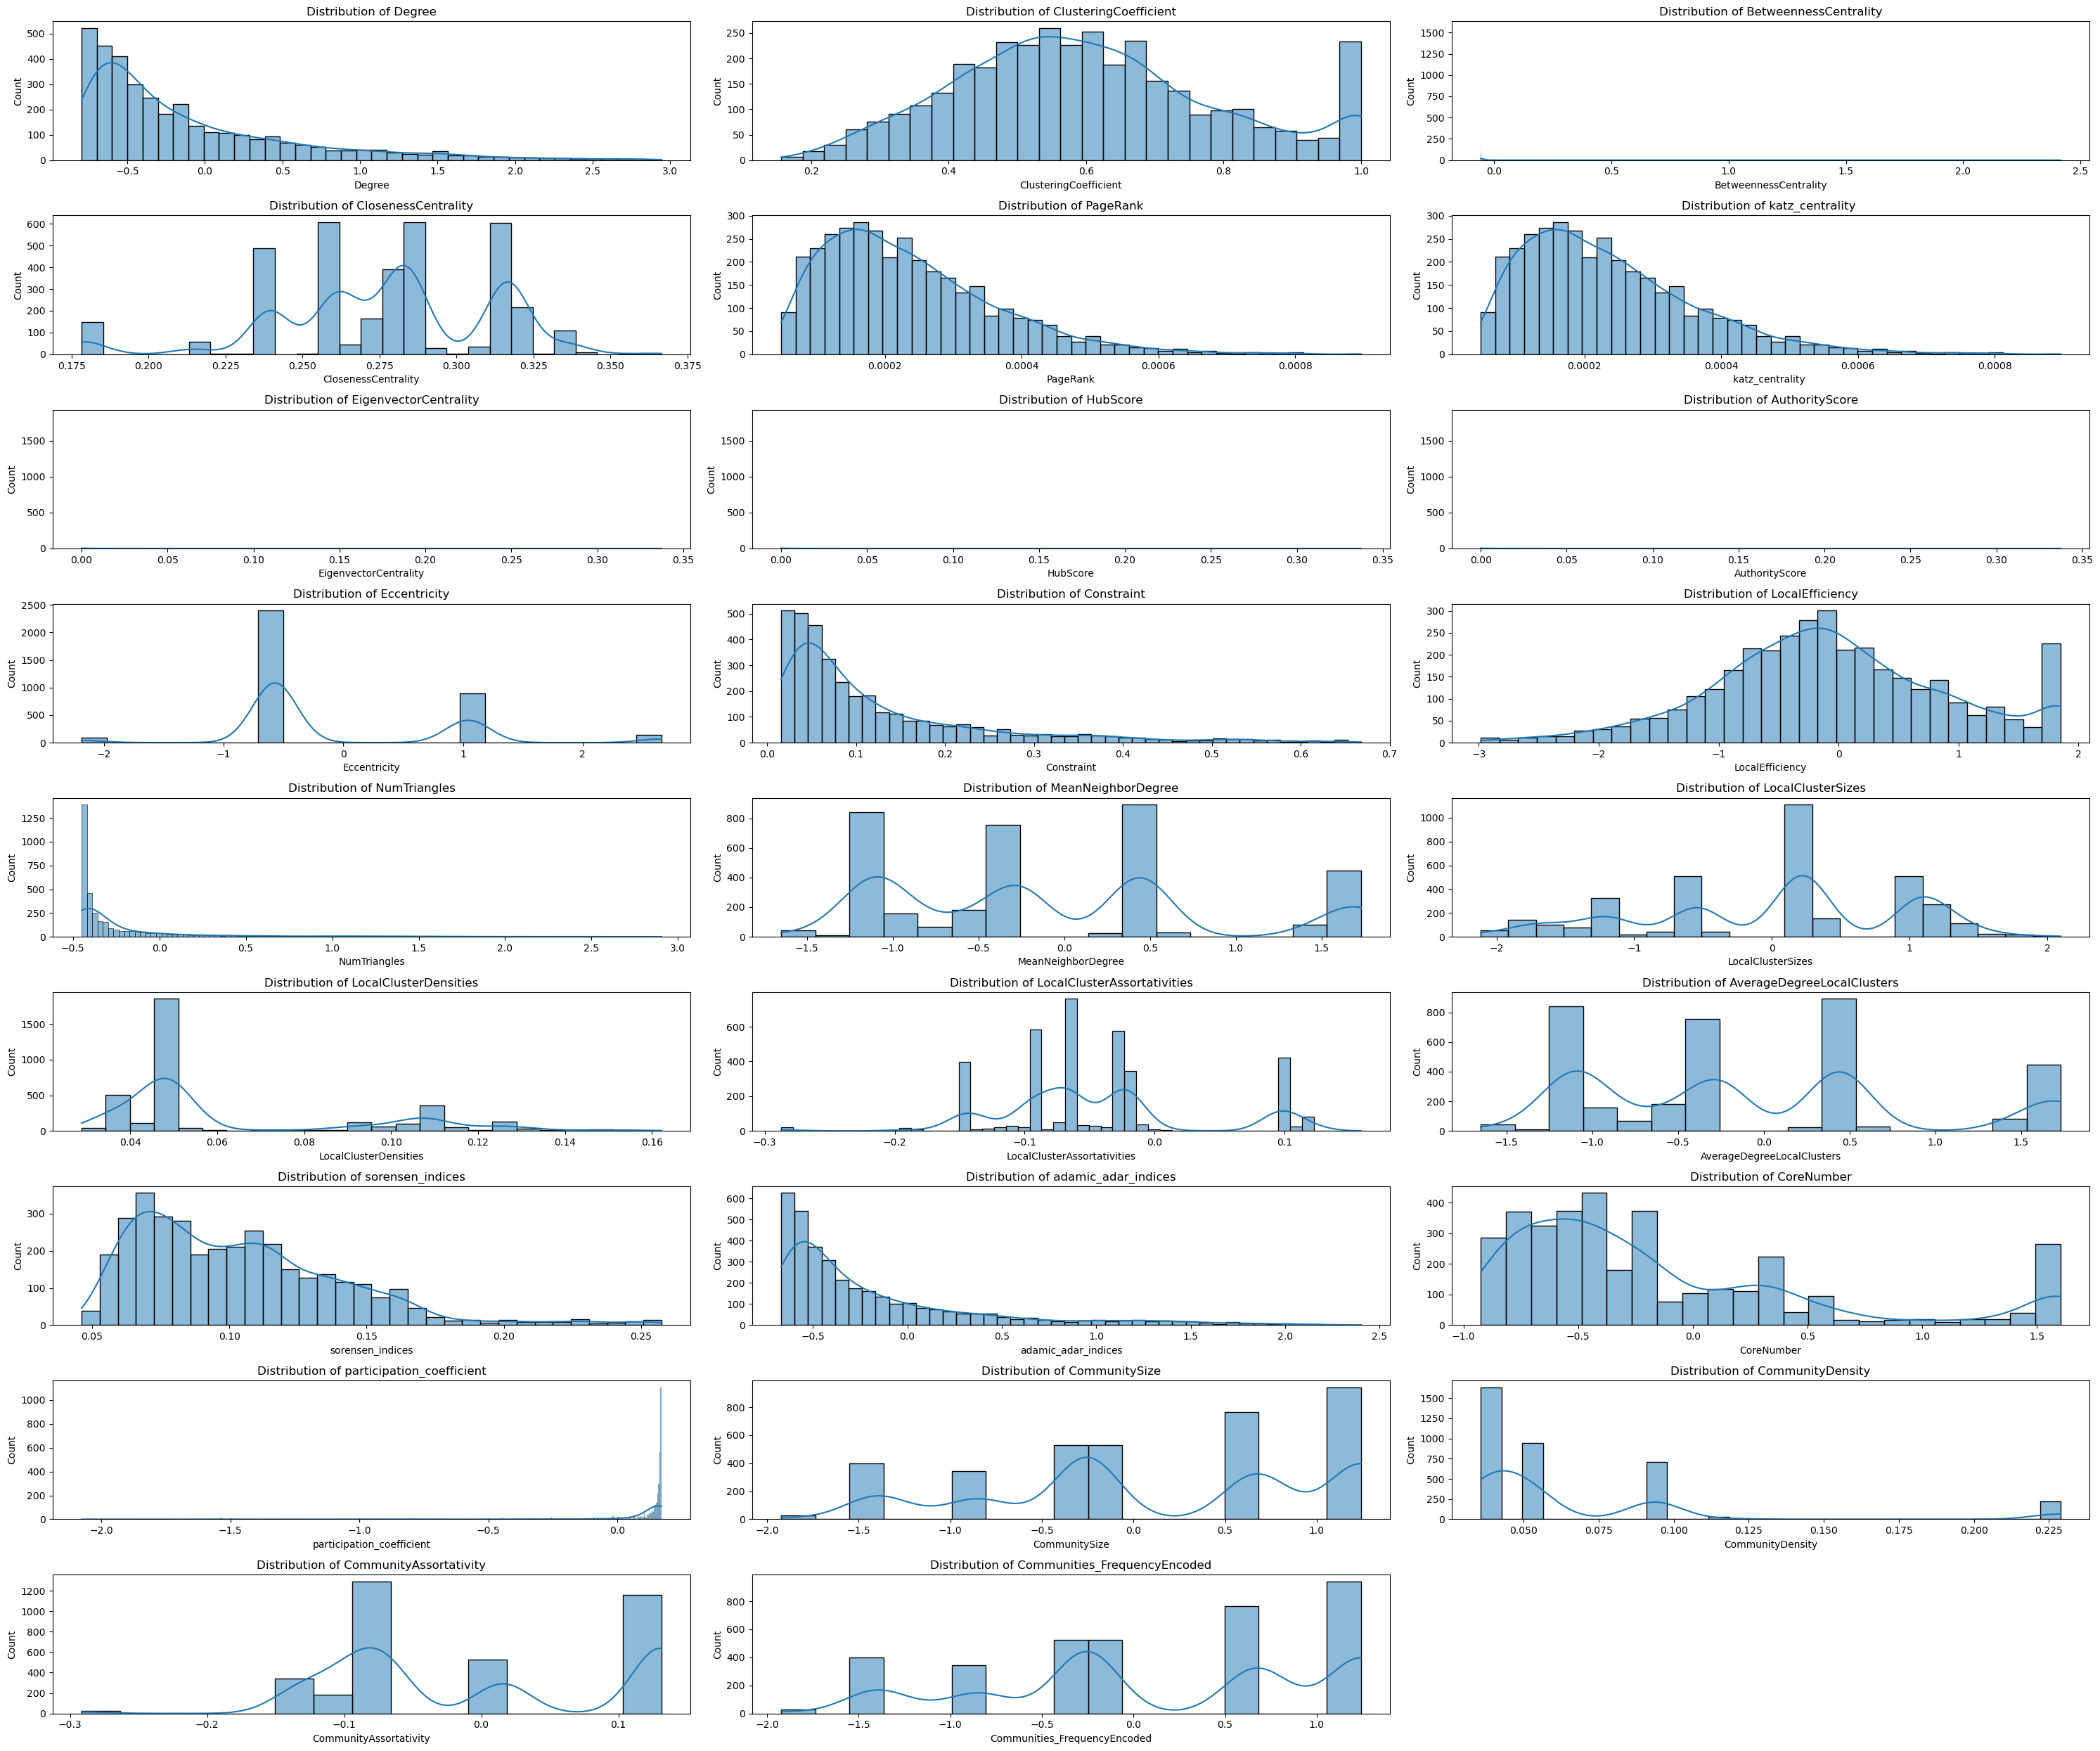

In [30]:
import seaborn as sns

# Visualize the distribution of each feature
plt.figure(figsize=(30, 25))
for i, column in enumerate(cleaned_df.columns[1:], 1):
    plt.subplot(9, 3, i)
    sns.histplot(cleaned_df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

I plotted all the features and every feature looks close to normalized distrubution within a scale and now lets see blot plot how the outliers exist and looks still in the threshold range

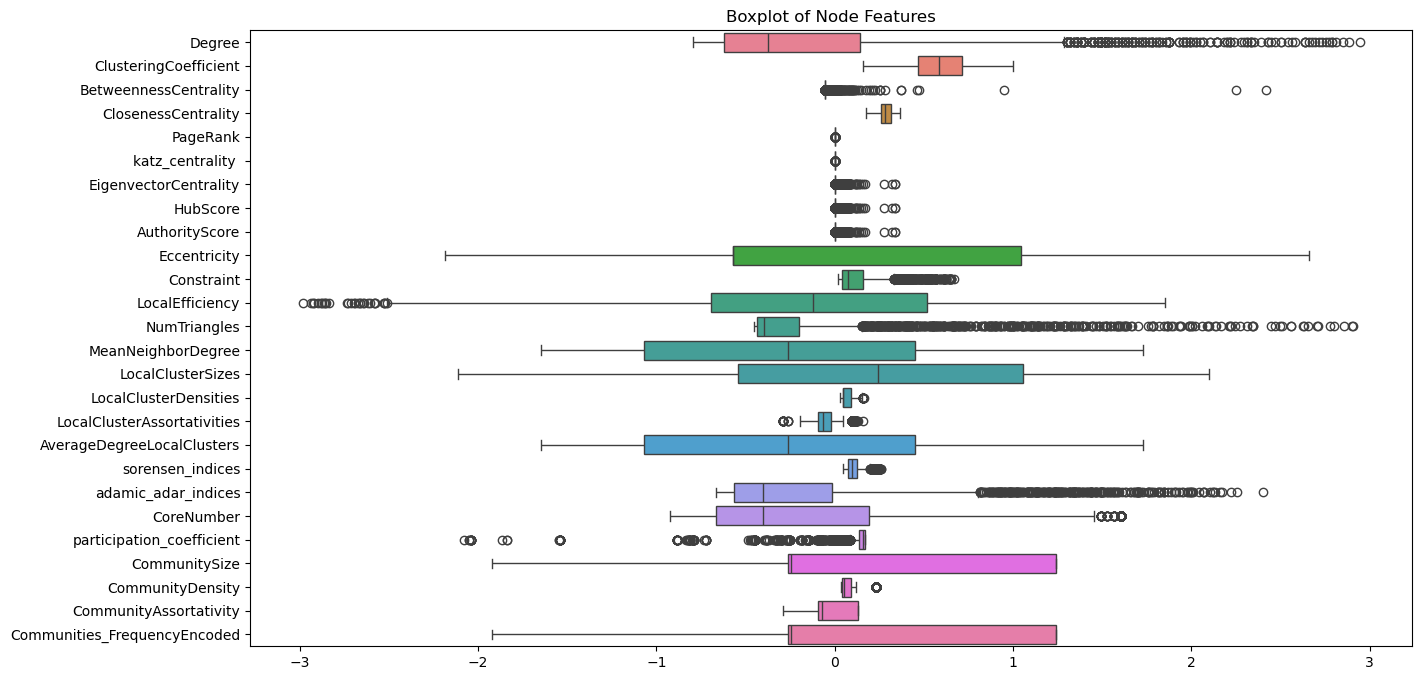

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cleaned_df is your DataFrame containing the data for the box plot
# Assuming 'Node' is the column you want to exclude from the plot

# Set the figure size
plt.figure(figsize=(15, 8))

# Create a vertical box plot
sns.boxplot(data=cleaned_df.drop(columns=['Node']), orient='h')

# Add title and show the plot
plt.title('Boxplot of Node Features')
plt.show()

/tmp/ipykernel_2468/2766103192.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


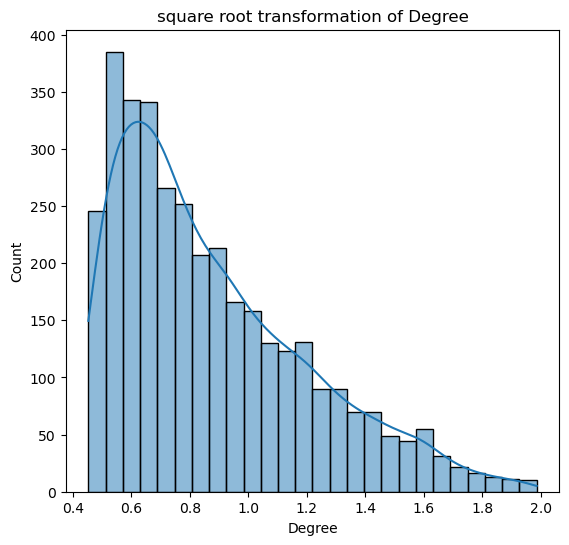

/tmp/ipykernel_2468/2766103192.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


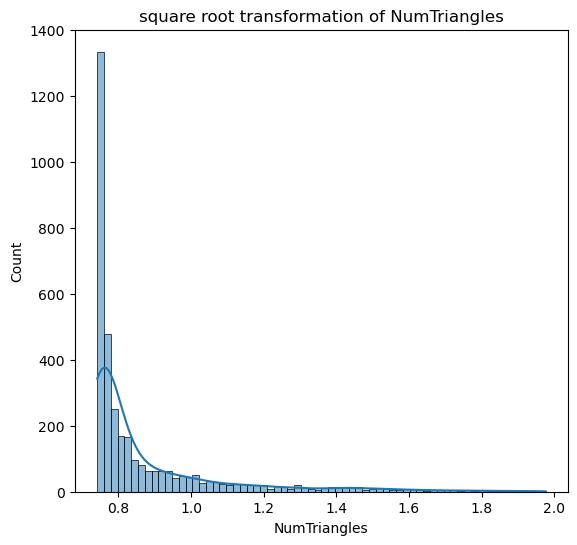

/tmp/ipykernel_2468/2766103192.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


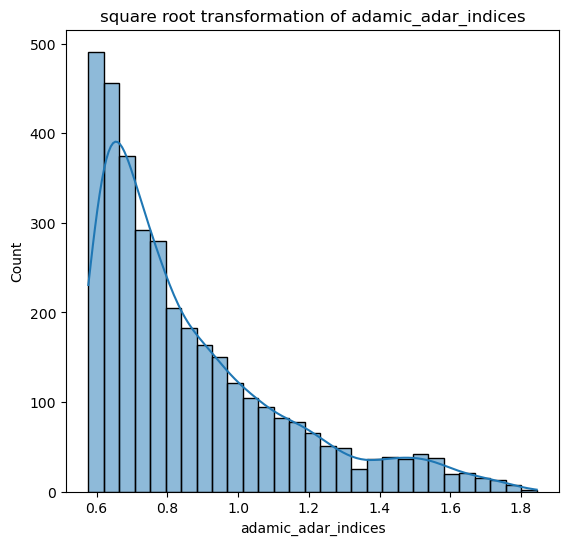

/tmp/ipykernel_2468/2766103192.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


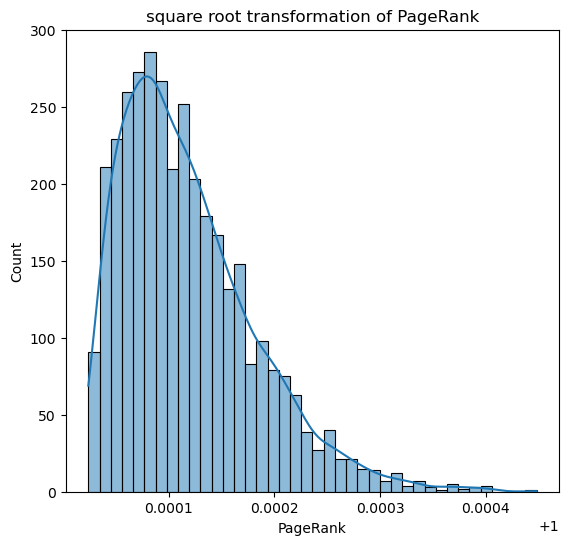

/tmp/ipykernel_2468/2766103192.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


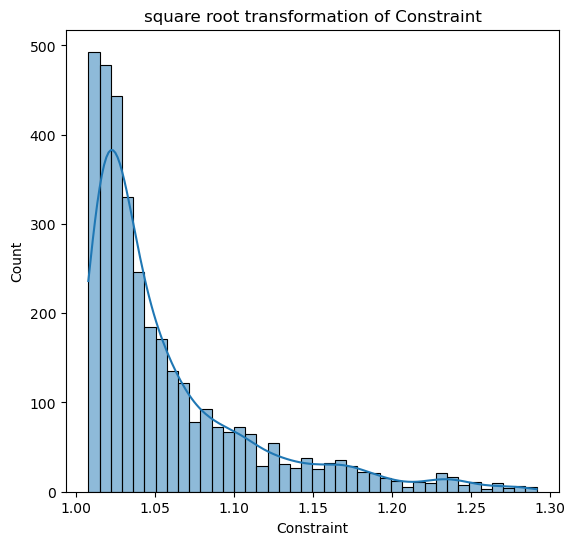

/tmp/ipykernel_2468/2766103192.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


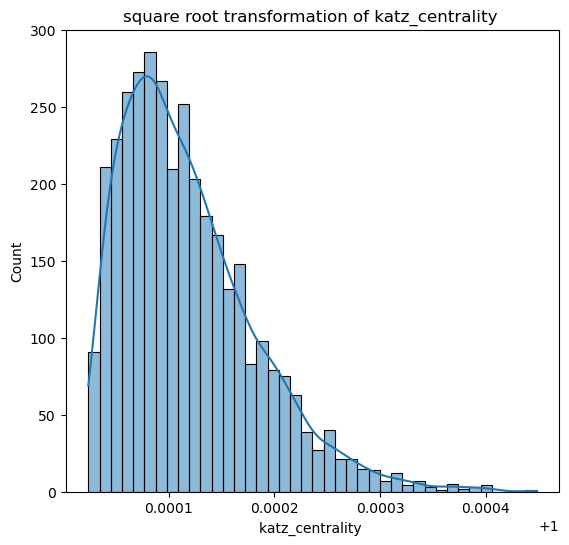

/opt/conda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2468/2766103192.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


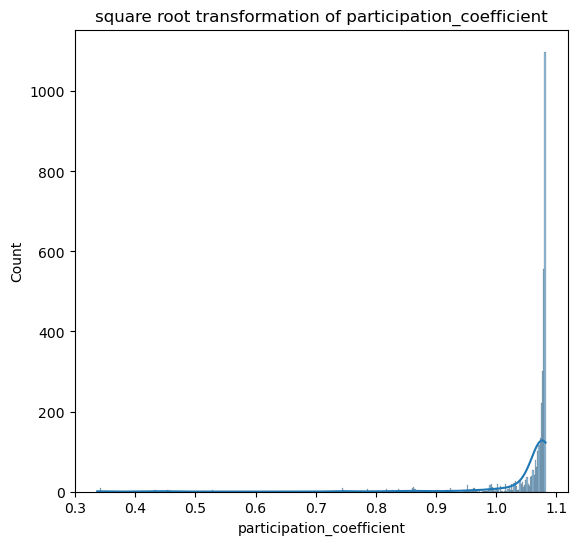

,Node,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,katz_centrality,EigenvectorCentrality,HubScore,AuthorityScore,...,LocalClusterAssortativities,AverageDegreeLocalClusters,sorensen_indices,adamic_adar_indices,CoreNumber,participation_coefficient,CommunitySize,CommunityDensity,CommunityAssortativity,Communities_FrequencyEncoded
1,1,0.700547,0.419118,-0.057036,0.261376,1.000118,1.000118,0.000006,0.000006,0.000006,...,-0.141855,-1.206914,0.128317,0.768420,-0.515967,1.078821,-0.849481,0.042446,-0.133841,-0.849481
2,2,0.597675,0.888889,-0.057268,0.261258,1.000100,1.000100,0.000002,0.000002,0.000002,...,-0.141855,-1.206914,0.122203,0.666309,-0.664664,1.073933,-0.849481,0.042446,-0.133841,-0.849481
3,3,0.700547,0.632353,-0.057130,0.261376,1.000113,1.000113,0.000007,0.000007,0.000007,...,-0.141855,-1.206914,0.143140,0.810941,-0.515967,1.078447,-0.849481,0.042446,-0.133841,-0.849481
4,4,0.597675,0.866667,-0.057259,0.261258,1.000116,1.000116,0.000002,0.000002,0.000002,...,-0.141855,-1.206914,0.110459,0.643592,-0.664664,1.074068,-0.849481,0.042446,-0.133841,-0.849481
5,5,0.643779,0.333333,-0.057085,0.261308,1.000101,1.000101,0.000012,0.000012,0.000012,...,-0.141855,-1.206914,0.119667,0.717127,-0.627490,1.076862,-0.849481,0.042446,-0.133841,-0.849481


In [32]:
#Applying square root trannsformation to reduce the right skewedness of the below features

# Features to transform
features_to_transform = ['Degree', 'NumTriangles', 'adamic_adar_indices', 'PageRank', 'Constraint', 'katz_centrality ', 'participation_coefficient']

# Apply log transformation
for feature in features_to_transform:
    # To handle zero values, we add 1 before taking the log
    cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)

    # Plot original and transformed distributions
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(cleaned_df[feature], kde=True)
    plt.title(f'square root transformation of {feature}')
    plt.show()

# Display the DataFrame with the new log-transformed features
cleaned_df.head()

In [33]:
cleaned_df.describe()

,Node,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,katz_centrality,EigenvectorCentrality,HubScore,AuthorityScore,...,LocalClusterAssortativities,AverageDegreeLocalClusters,sorensen_indices,adamic_adar_indices,CoreNumber,participation_coefficient,CommunitySize,CommunityDensity,CommunityAssortativity,Communities_FrequencyEncoded
count,3532.000000,3532.000000,3532.000000,3532.000000,3532.000000,3532.000000,3532.000000,3.532000e+03,3.532000e+03,3.532000e+03,...,3532.000000,3532.000000,3532.000000,3532.000000,3532.000000,3503.000000,3532.000000,3532.000000,3532.000000,3532.000000
mean,2020.874009,0.876742,0.602025,-0.049902,0.277151,1.000118,1.000118,4.369604e-03,4.369604e-03,4.369604e-03,...,-0.045620,-0.069014,0.103005,0.863715,-0.143319,1.052123,0.147582,0.066134,-0.004679,0.147582
std,1184.378842,0.327260,0.190844,0.065122,0.035163,0.000064,0.000064,1.771517e-02,1.771517e-02,1.771517e-02,...,0.075437,0.941786,0.037612,0.267876,0.697821,0.086384,0.908233,0.046865,0.104932,0.908233
min,1.000000,0.452310,0.156303,-0.057275,0.178262,1.000024,1.000024,3.834799e-13,3.834766e-13,3.834874e-13,...,-0.287404,-1.649258,0.046191,0.576389,-0.924884,0.336954,-1.922645,0.035736,-0.291613,-1.922645
25%,993.750000,0.613428,0.467836,-0.057234,0.260180,1.000071,1.000071,4.527026e-07,4.527026e-07,4.527026e-07,...,-0.093096,-1.067173,0.072822,0.658116,-0.664664,1.065250,-0.263184,0.040461,-0.092880,-0.263184
50%,1974.500000,0.790138,0.583333,-0.057015,0.282654,1.000106,1.000106,5.004465e-06,5.004465e-06,5.004465e-06,...,-0.066712,-0.262062,0.096120,0.771615,-0.404444,1.077372,-0.246041,0.052822,-0.069923,-0.246041
75%,3087.250000,1.067449,0.714286,-0.055853,0.315124,1.000153,1.000153,6.942540e-05,6.942540e-05,6.942540e-05,...,-0.022631,0.451196,0.123482,0.992247,0.190344,1.080319,1.241988,0.093474,0.130444,1.241988
max,4037.000000,1.985959,1.000000,2.416186,0.366558,1.000448,1.000448,3.373680e-01,3.373680e-01,3.373680e-01,...,0.159035,1.729940,0.257391,1.844462,1.602967,1.081847,1.241988,0.228897,0.131477,1.241988


## Exploratory Data Analysis (EDA) observations from your facebook_combined social network clustering project.

## Graph Topology & Layout:

The Fruchterman-Reingold layout scatter plot clearly reveals visually separated communities or clusters.

The graph is connected (is_connected=True) with 4039 nodes and no self-loops or isolated nodes after preprocessing.

Visibly dense node clusters suggest community structure — validating clustering as a meaningful next step.

## Node Feature Distributions

From the histograms and boxplots:

Features like Degree, BetweennessCentrality, PageRank, Katz Centrality, and Adamic-Adar Index are highly right-skewed.

You correctly applied square root transformations on such features (good preprocessing).

## Outliers:

Boxplots indicate many extreme values, especially in:

BetweennessCentrality,

ParticipationCoefficient   and

NumTriangles

These are expected in social networks (influential hubs, bridges). Outlier removal is reasonable if you plan to cluster typical users only.

## Summary Statistics Insights:

Degree: Ranges from 1 to 1045. Indicates presence of supernodes/hubs.


ClusteringCoefficient: Mean ~0.61. Many nodes are in well-connected local neighborhoods.

BetweennessCentrality: Median ≪ Mean --> heavily right-skewed, very few nodes control flow.


EigenvectorCentrality: Most values are close to zero, only a few influential nodes.


ParticipationCoefficient: Abnormally high magnitude negatives (e.g., -1.09M min) suggest an error. This may be due to division issues or scale drift. Needs fixing or capping.

CommunitySize: Wide variation: 6 to 982 — confirms heterogeneous community structure


CommunityDensity: Mostly low (<0.1) --> sparse communities, which is typical in real-world graphs.


CommunityAssortativity: Mostly negative --> disassortative mixing (low-degree nodes connect with high-degree ones).


## Dimensional Distributions:

From your PCA plots and histograms:

Features like LocalEfficiency, LocalClusterAssortativity, and AverageDegreeLocalClusters show bimodal or multi-modal behavior — suggesting potential natural clusters.

CoreNumber distribution reflects hierarchical layering, with some deeply embedded nodes.


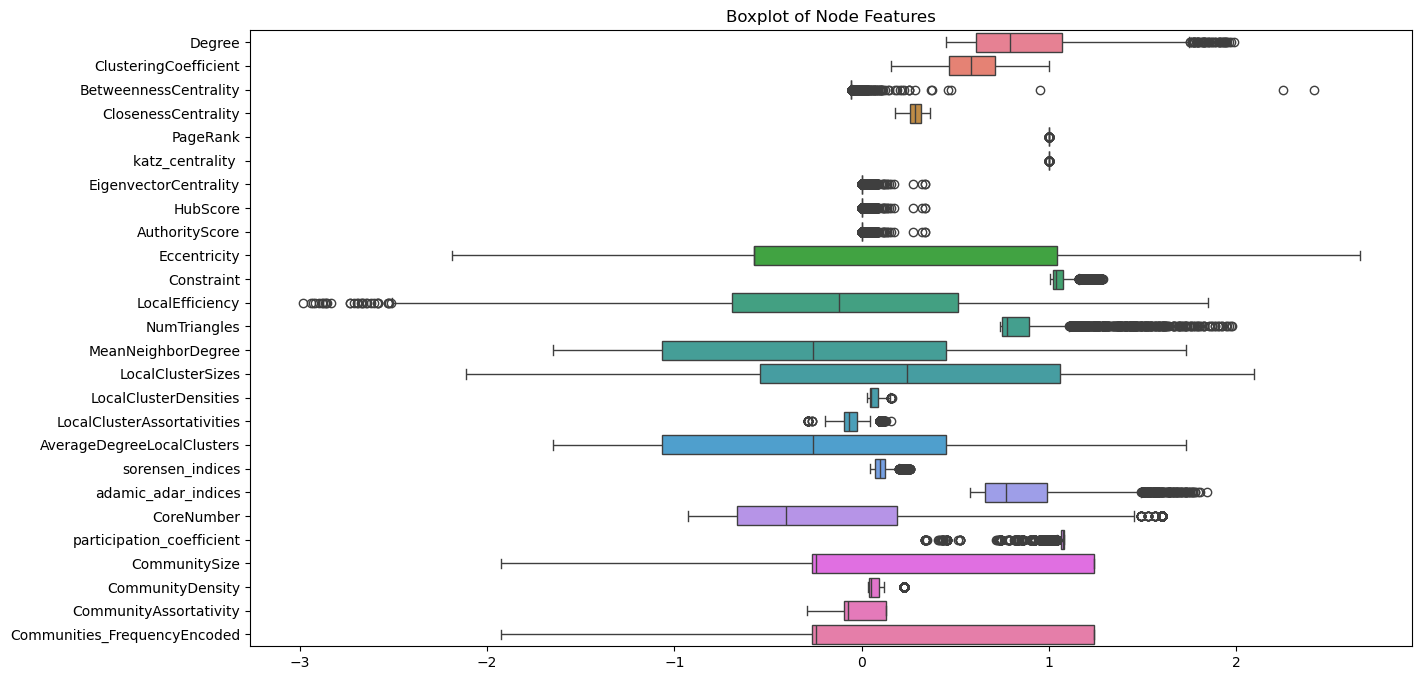

In [34]:
# cleaned_df is your DataFrame containing the data for the box plot
# 'Node' is the column you want to exclude from the plot

# Set the figure size
plt.figure(figsize=(15, 8))

# Create a vertical box plot
sns.boxplot(data=cleaned_df.drop(columns=['Node']), orient='h')

# Add title and show the plot
plt.title('Boxplot of Node Features')
plt.show()

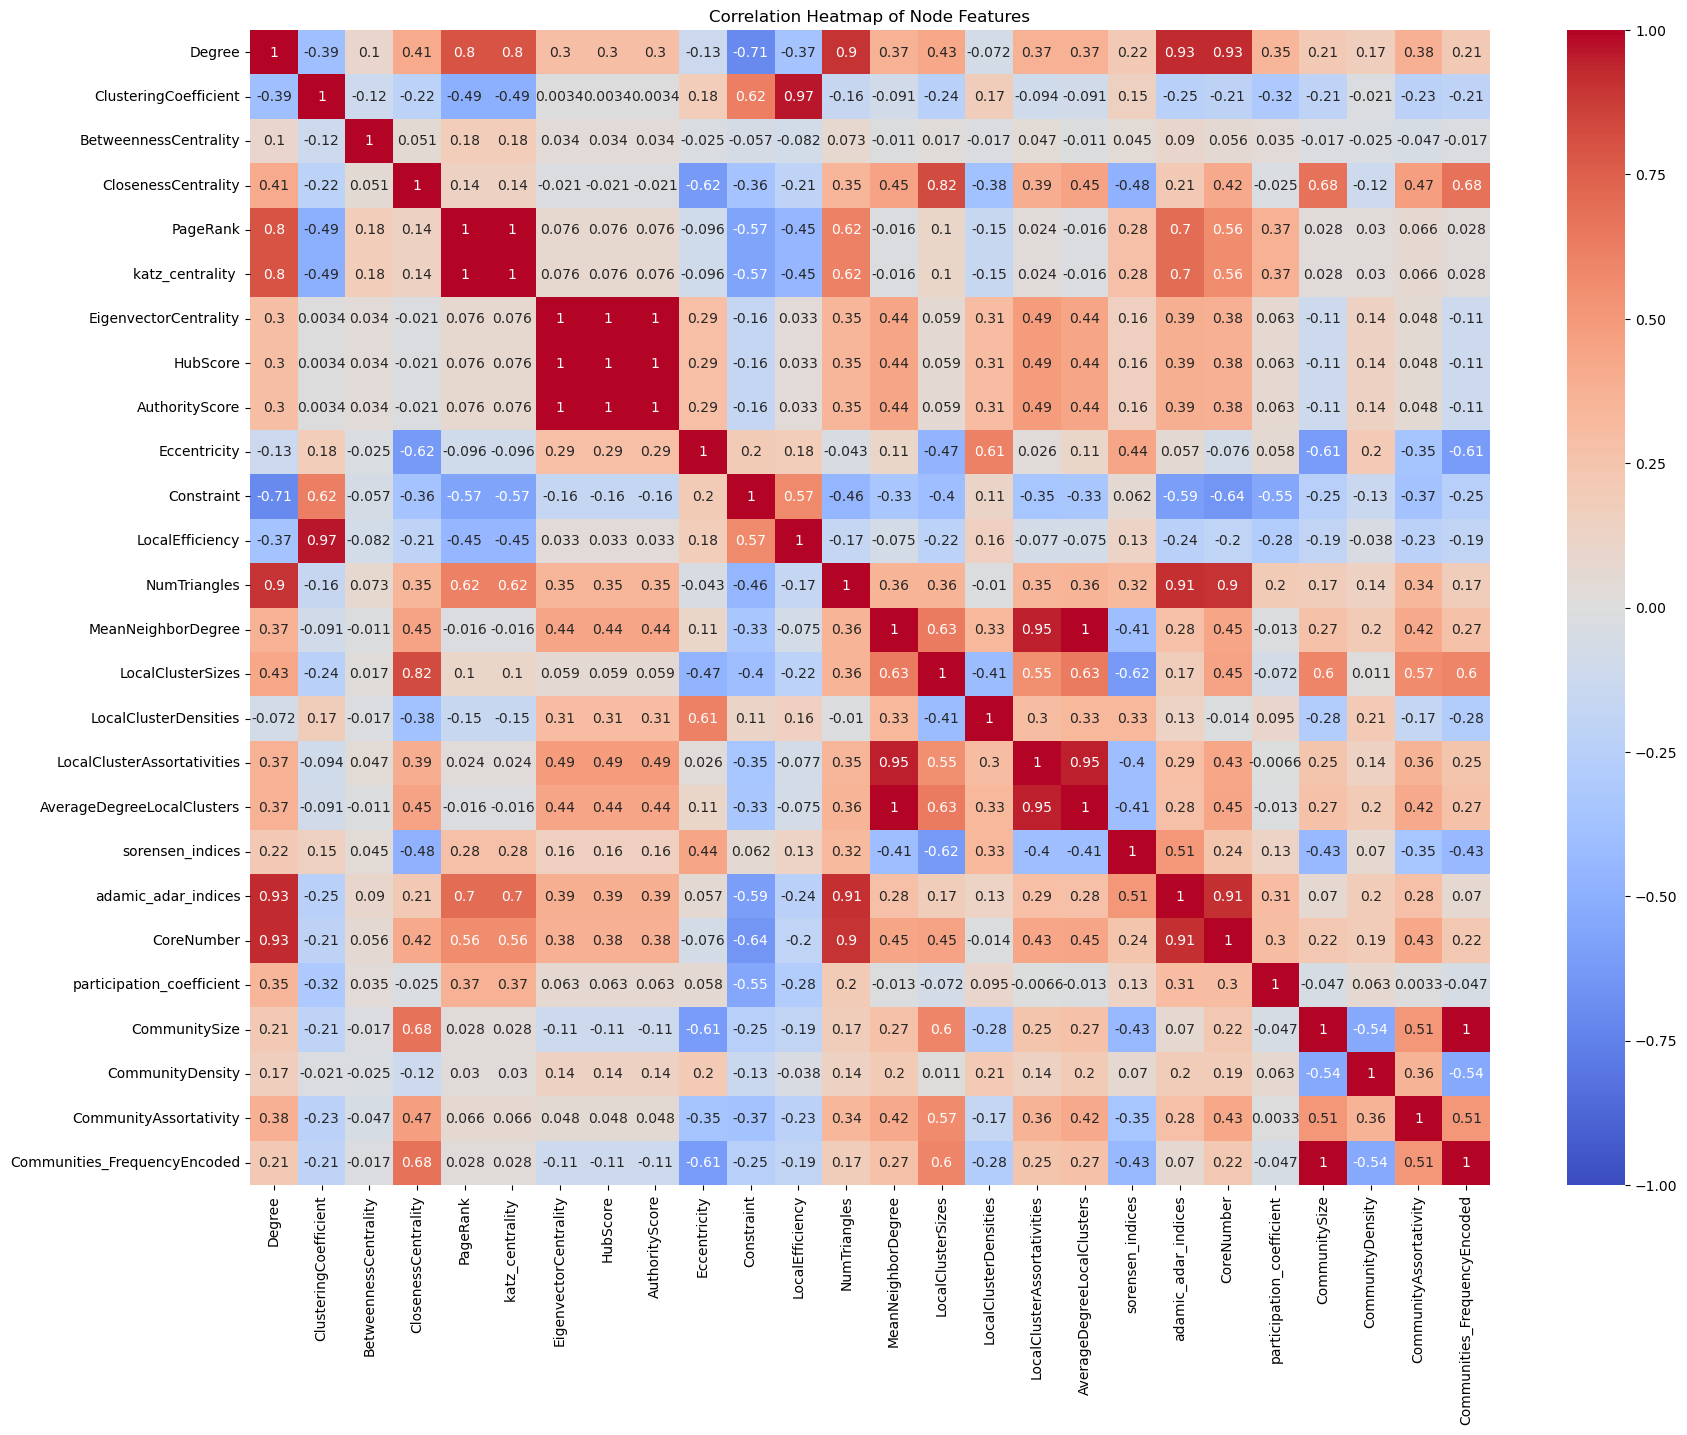

In [35]:
# Correlation heatmap to show relationships between features
plt.figure(figsize=(20, 15))
correlation_matrix = cleaned_df.drop(columns=['Node']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Node Features')
plt.show()

dropped the features which are highly correlated in the above heatmap and preserve the important features to get maximum information for clustering.

In [36]:
df_dropped = cleaned_df.drop(columns=['HubScore','AuthorityScore','LocalClusterAssortativities','Communities_FrequencyEncoded',
                                      'AverageDegreeLocalClusters','NumTriangles','CoreNumber','LocalEfficiency','katz_centrality ','adamic_adar_indices'])

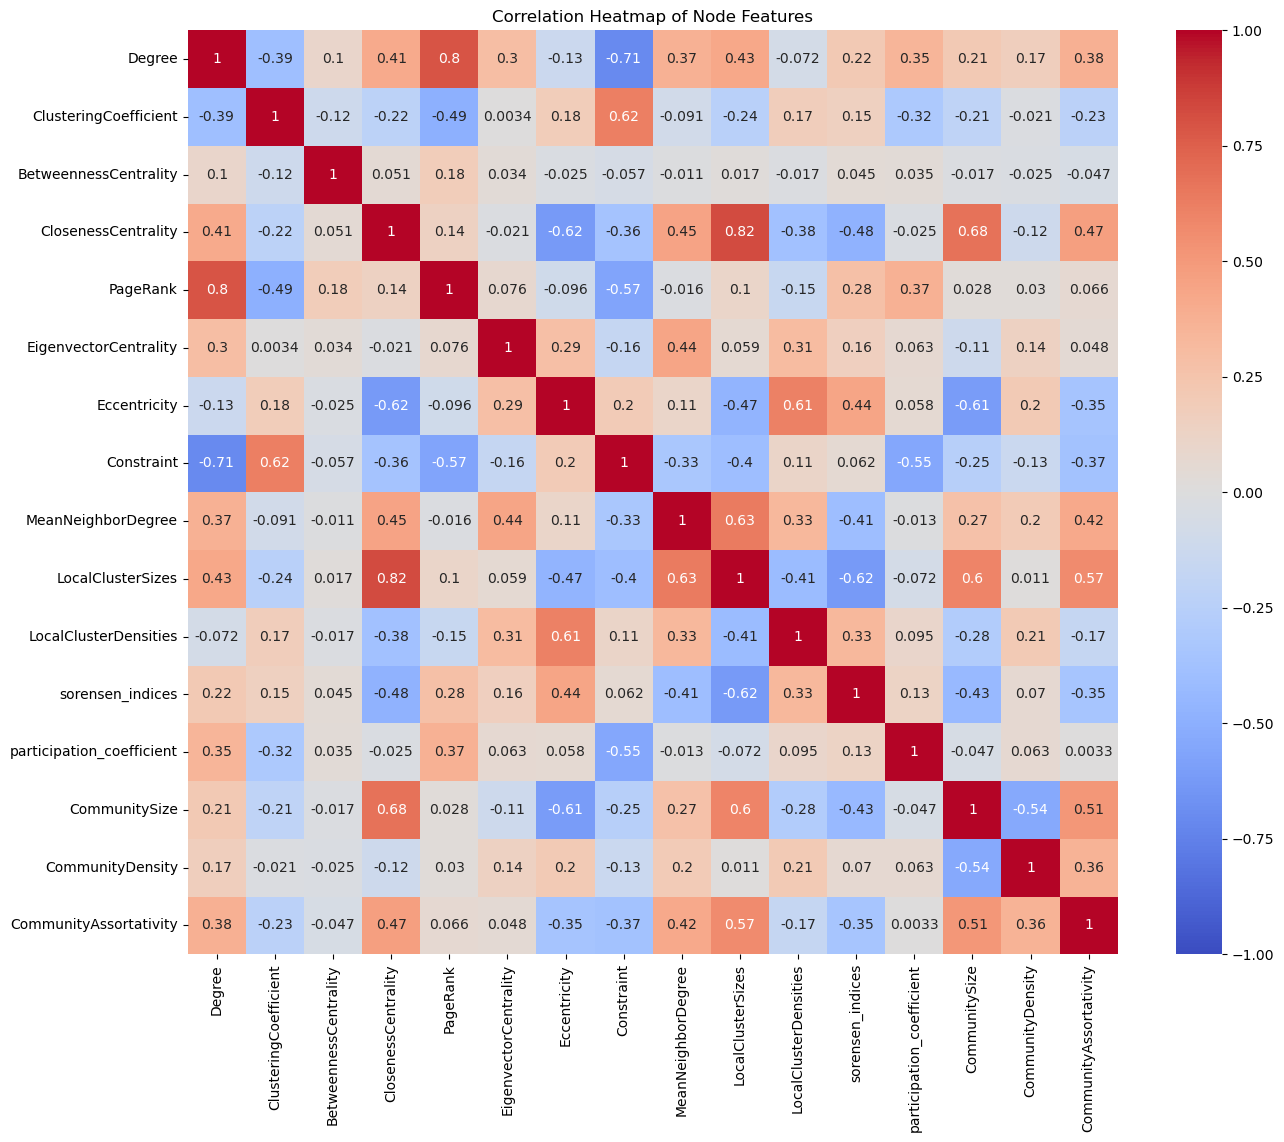

In [37]:
# Correlation heatmap to show relationships between features
plt.figure(figsize=(15, 12))
correlation_matrix = df_dropped.drop(columns=['Node']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Node Features')
plt.show()

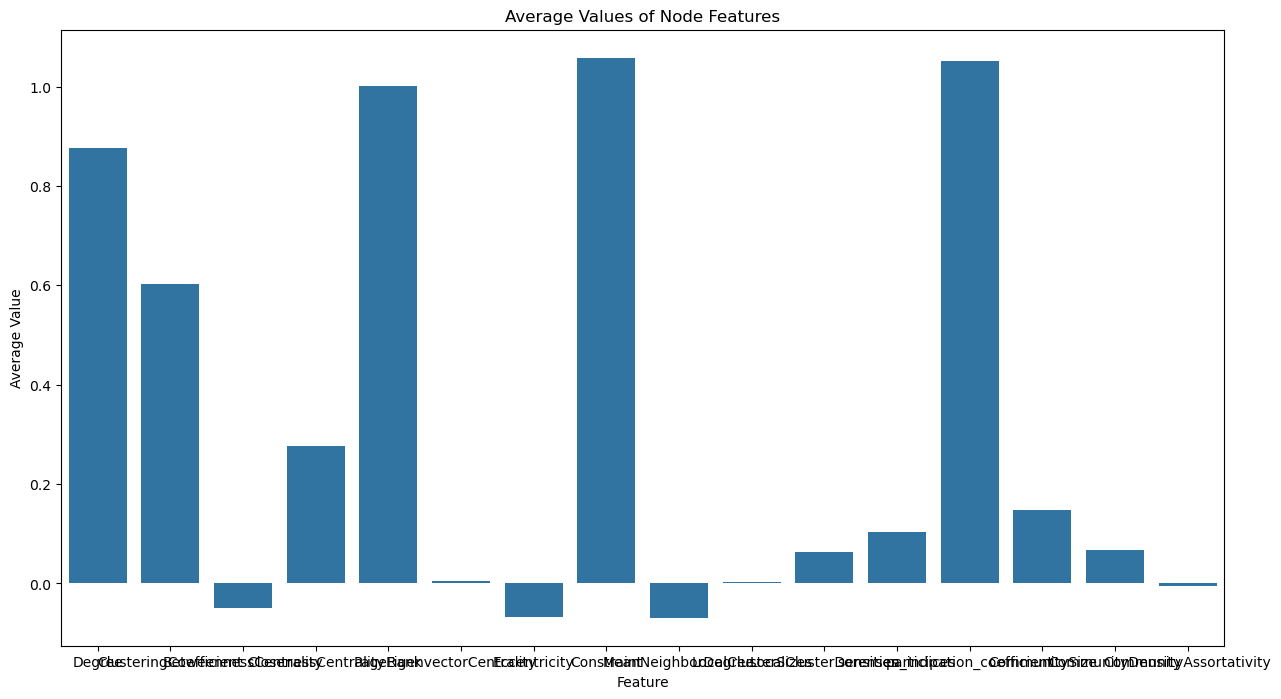

In [38]:
# Bar plot to show the average values of each feature
plt.figure(figsize=(15, 8))
sns.barplot(data=df_dropped.drop(columns=['Node']).mean().reset_index(), x='index', y=0)
plt.title('Average Values of Node Features')
plt.ylabel('Average Value')
plt.xlabel('Feature')
plt.show()

In [39]:
# Check for null values in each column
null_values_per_column = df_dropped.isnull().sum()
print("Null values per column:")
print(null_values_per_column)

Null values per column:
Node                          0
Degree                        0
ClusteringCoefficient         0
BetweennessCentrality         0
ClosenessCentrality           0
PageRank                      0
EigenvectorCentrality         0
Eccentricity                  0
Constraint                    0
MeanNeighborDegree            0
LocalClusterSizes             0
LocalClusterDensities         0
sorensen_indices              0
participation_coefficient    29
CommunitySize                 0
CommunityDensity              0
CommunityAssortativity        0
dtype: int64


In [40]:
df_dropped.shape

(3532, 17)

In [41]:
from sklearn.impute import SimpleImputer

# Impute NaN values only for specific columns with the mean of each column
columns_to_impute = ['participation_coefficient']
imputer = SimpleImputer(strategy='mean')
df_dropped.loc[:, columns_to_impute] = imputer.fit_transform(df_dropped[columns_to_impute])

In [42]:
df_dropped.shape

(3532, 17)

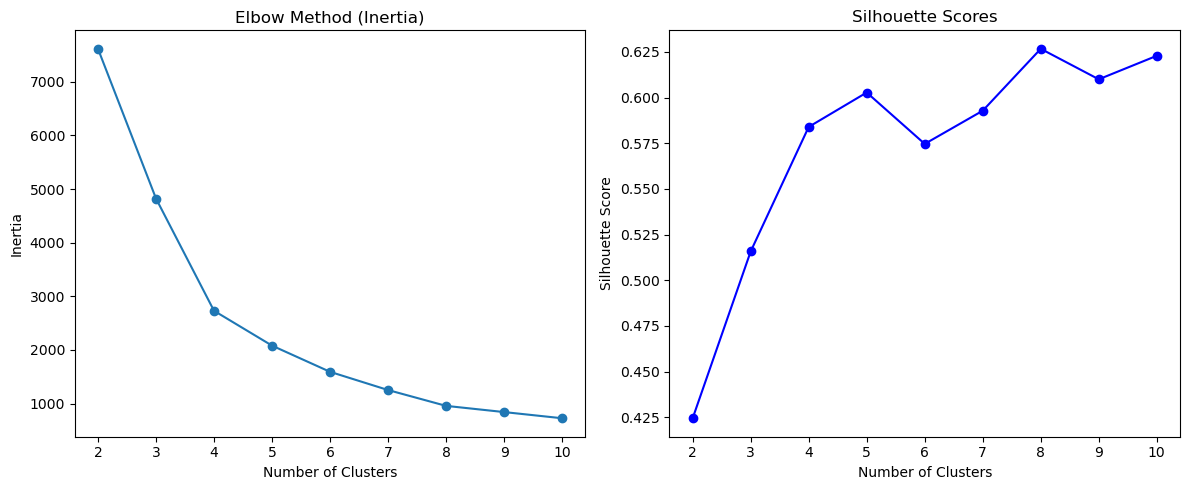

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_dropped.drop(columns=['Node']))  # drop Node if not dropped already
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_dropped.drop(columns=['Node']), labels))

# Elbow Plot (Inertia)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette, marker='o', color='blue', linestyle='-')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [48]:
best_score = -1
best_model = None
best_k = None

X = df_dropped.drop(columns=['Node'])  # Drop Node once here

for k in range(2, 11):
    for init_method in ['k-means++', 'random']:
        kmeans = KMeans(n_clusters=k, init=init_method, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X)
        sil_score = silhouette_score(X, labels)

        if sil_score > best_score:
            best_score = sil_score
            best_model = kmeans
            best_k = k

print(f"Best K: {best_k}, Silhouette Score: {best_score:.4f}")

Best K: 8, Silhouette Score: 0.6267


/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


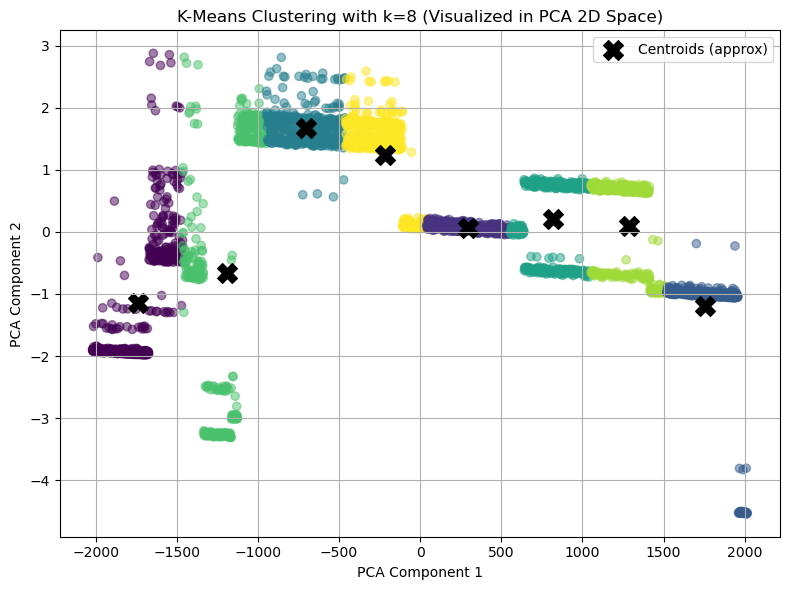

In [55]:
# Fit KMeans with k=8
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_dropped)

# Reduce to 2D using PCA for visualization
pca_vis = PCA(n_components=2)
X_2D = pca_vis.fit_transform(df_dropped)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(pca_vis.transform(kmeans.cluster_centers_)[:, 0],
            pca_vis.transform(kmeans.cluster_centers_)[:, 1],
            c='black', marker='X', s=200, label='Centroids (approx)')
plt.title("K-Means Clustering with k=8 (Visualized in PCA 2D Space)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_dropped.drop(columns=['Node']))

# Add cluster assignments to the DataFrame
df_dropped['Cluster'] = clusters

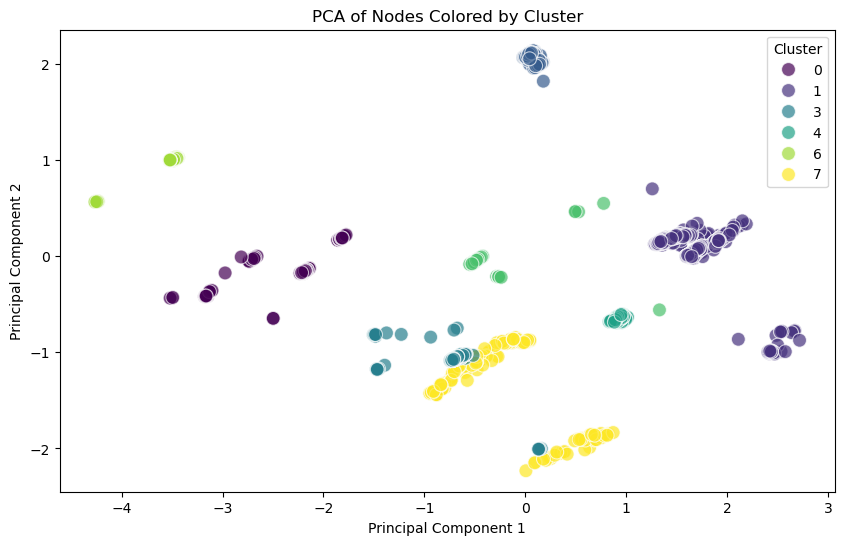

In [58]:
from sklearn.decomposition import PCA

# Perform PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_dropped.drop(columns=['Node', 'Cluster']))

# Create a DataFrame with PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('PCA of Nodes Colored by Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Visualize how the feature informations are clustering at optimal_k .Also we can find how the cluster sizes have been taken on each.The clustering size and number of clusters observed similar to the community detections on each node.

Cluster Sizes:
 1    940
3    546
2    528
4    512
0    370
7    258
5    231
6    147
Name: count, dtype: int64


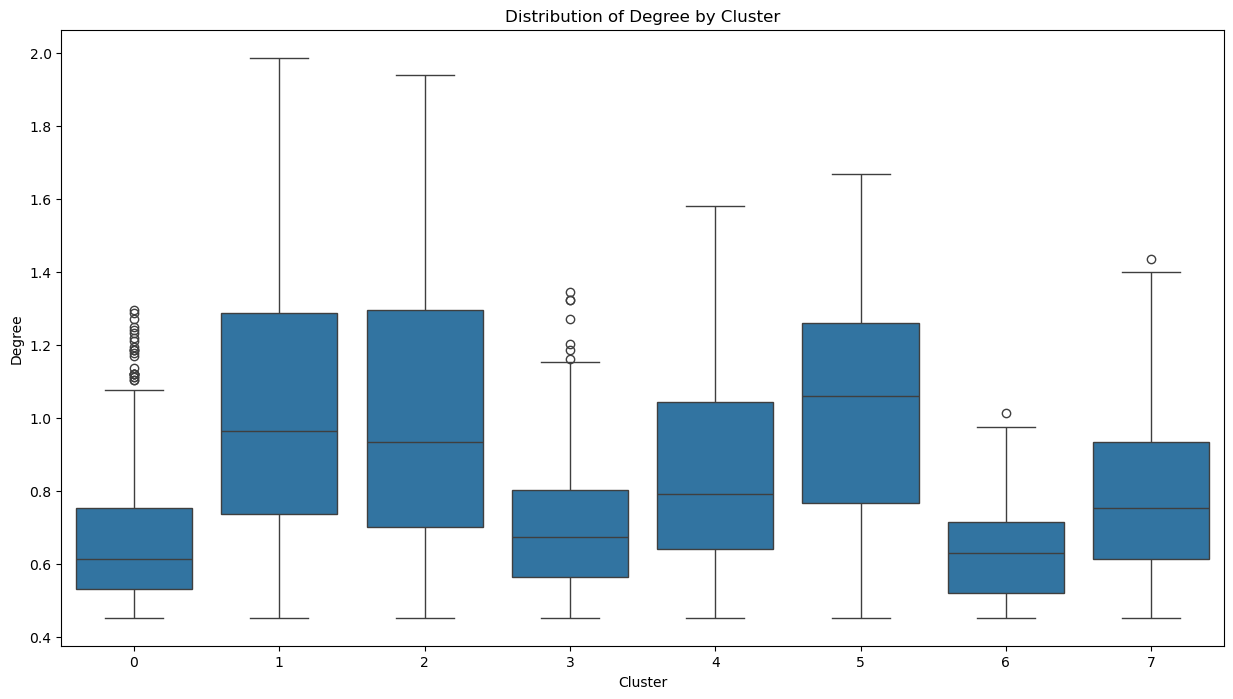

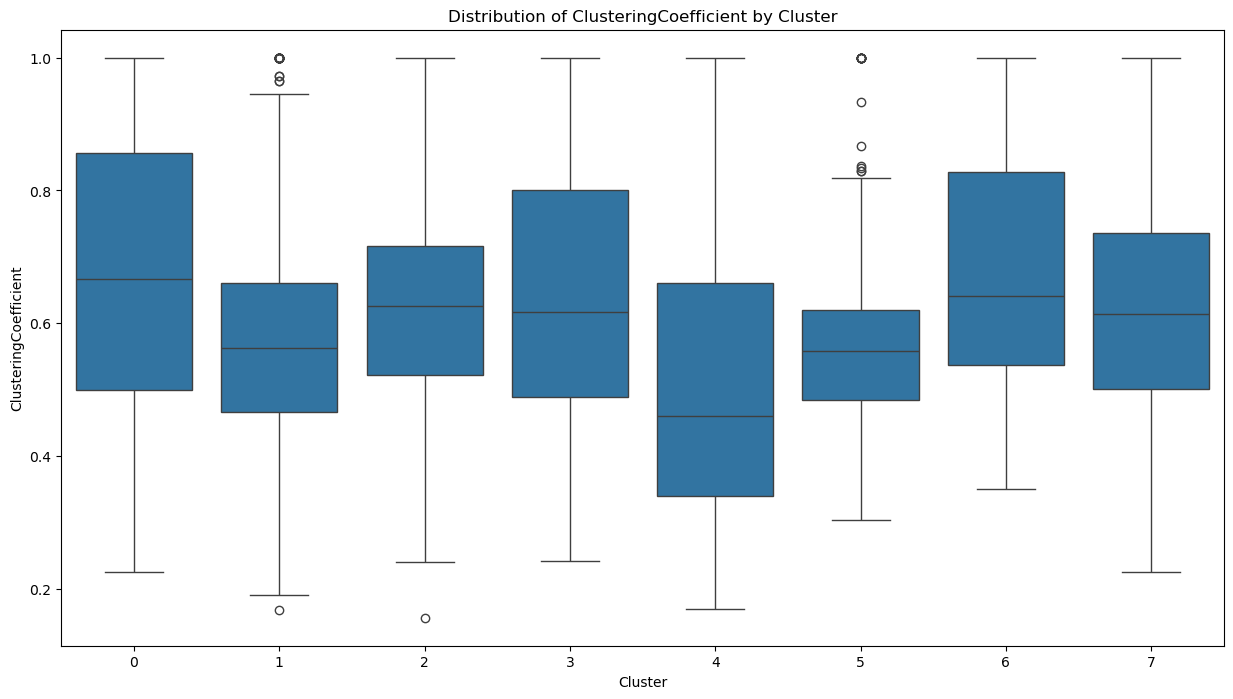

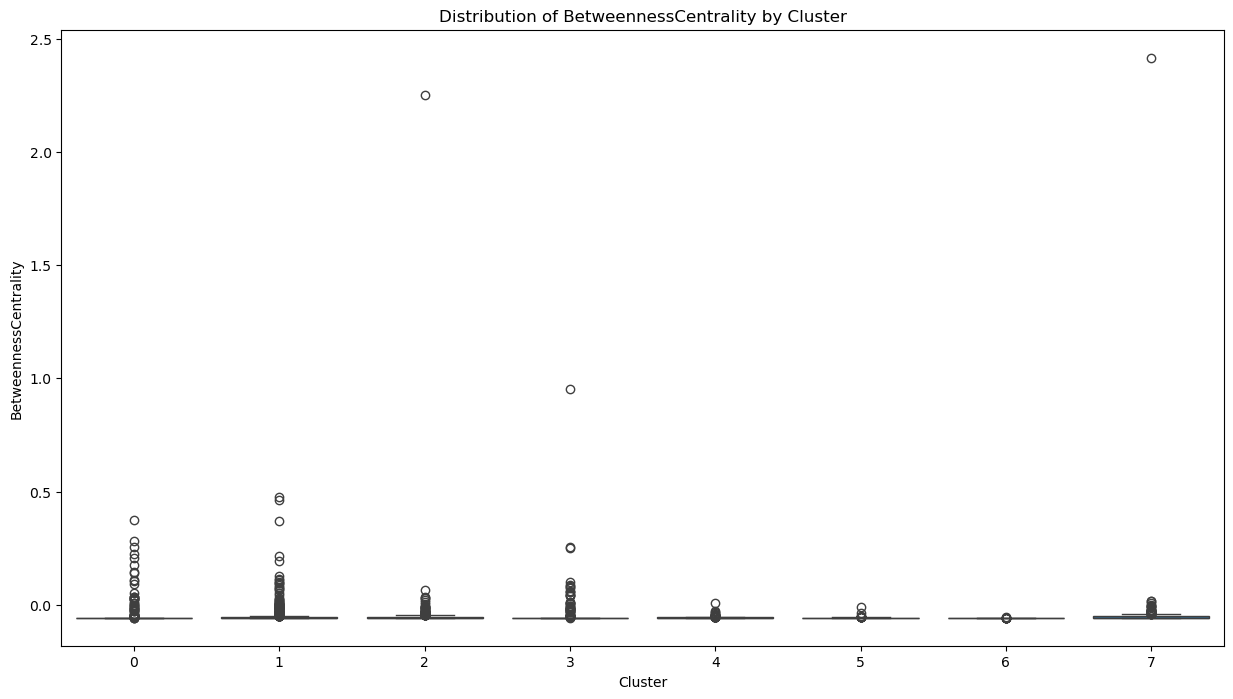

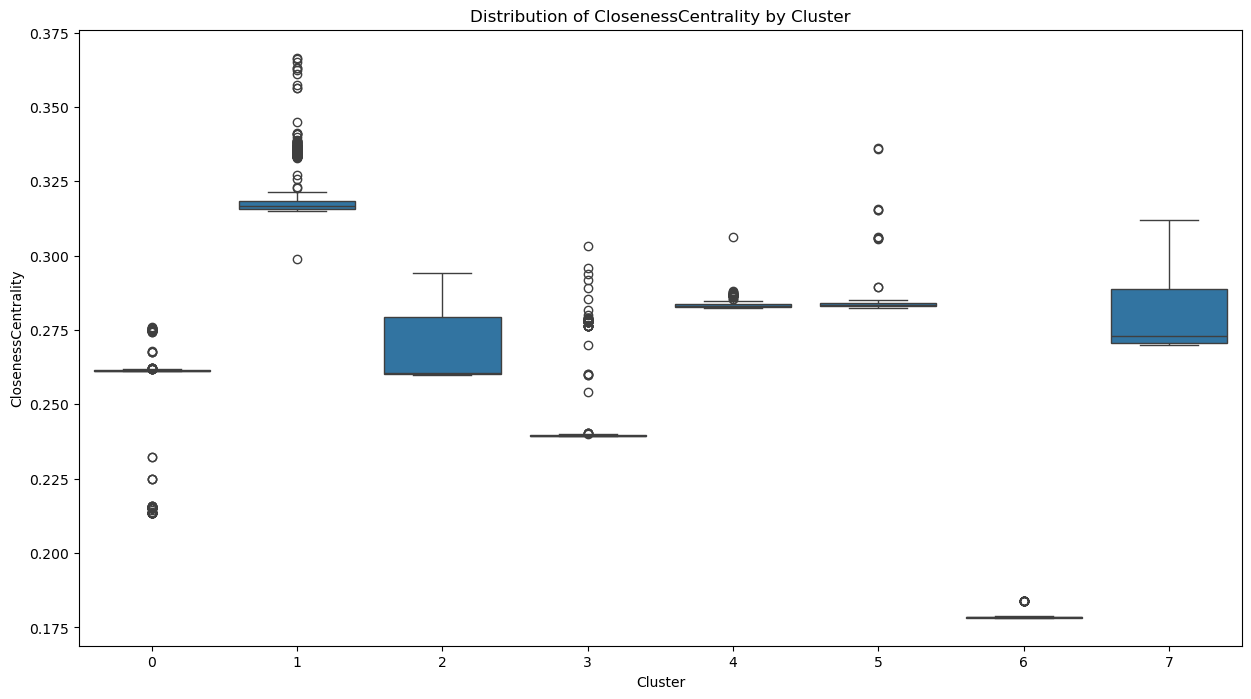

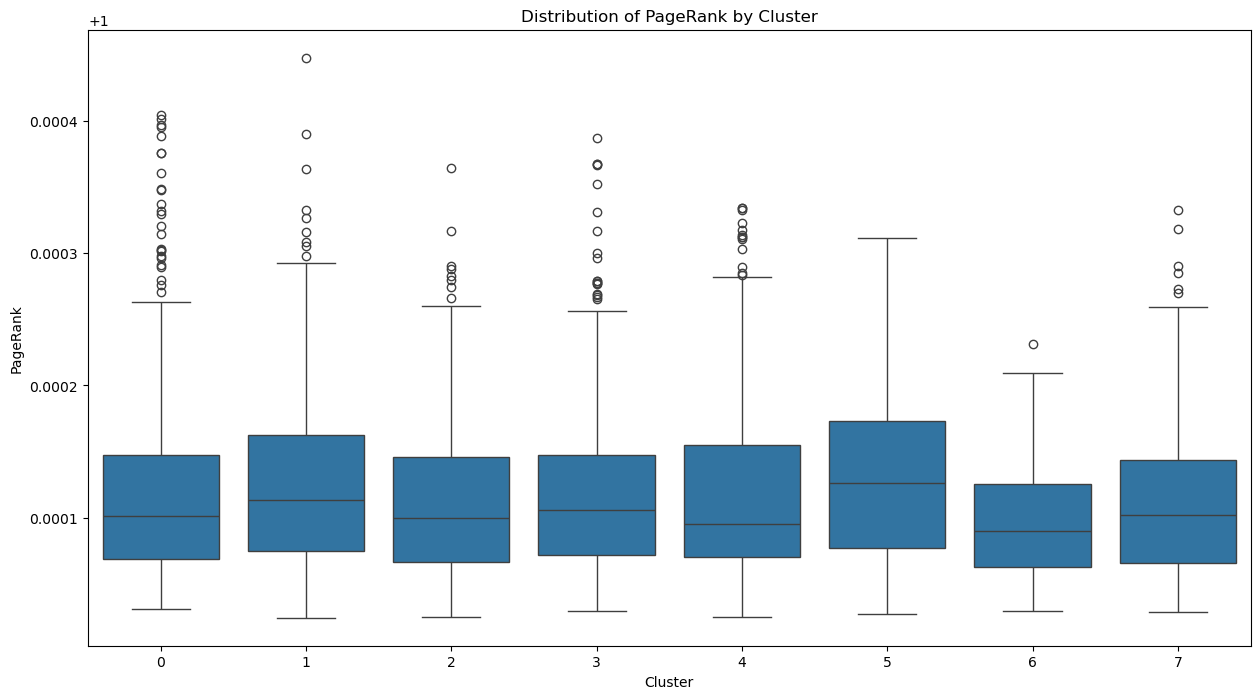

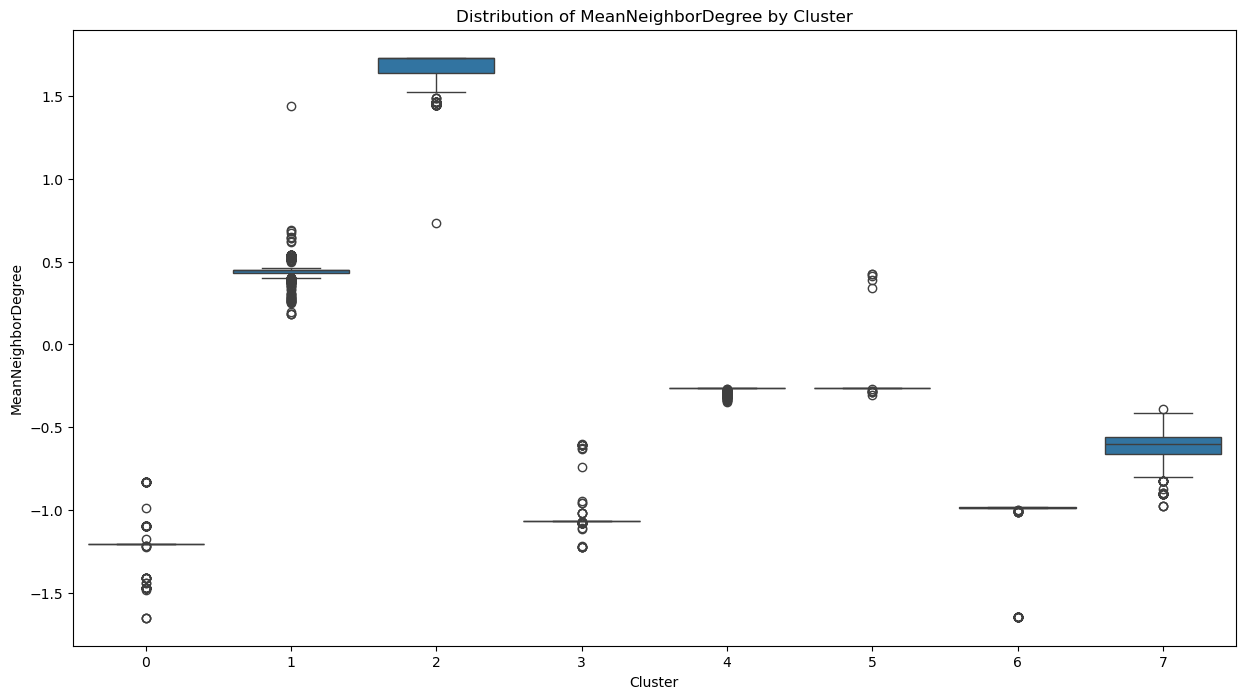

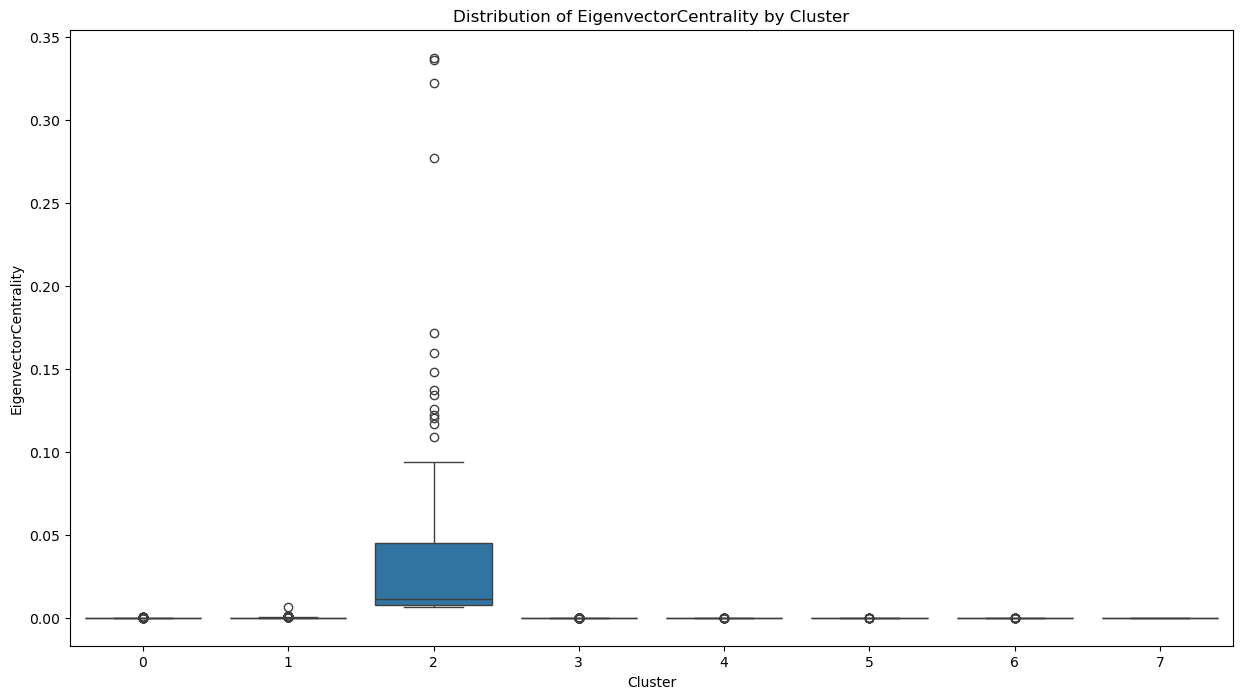

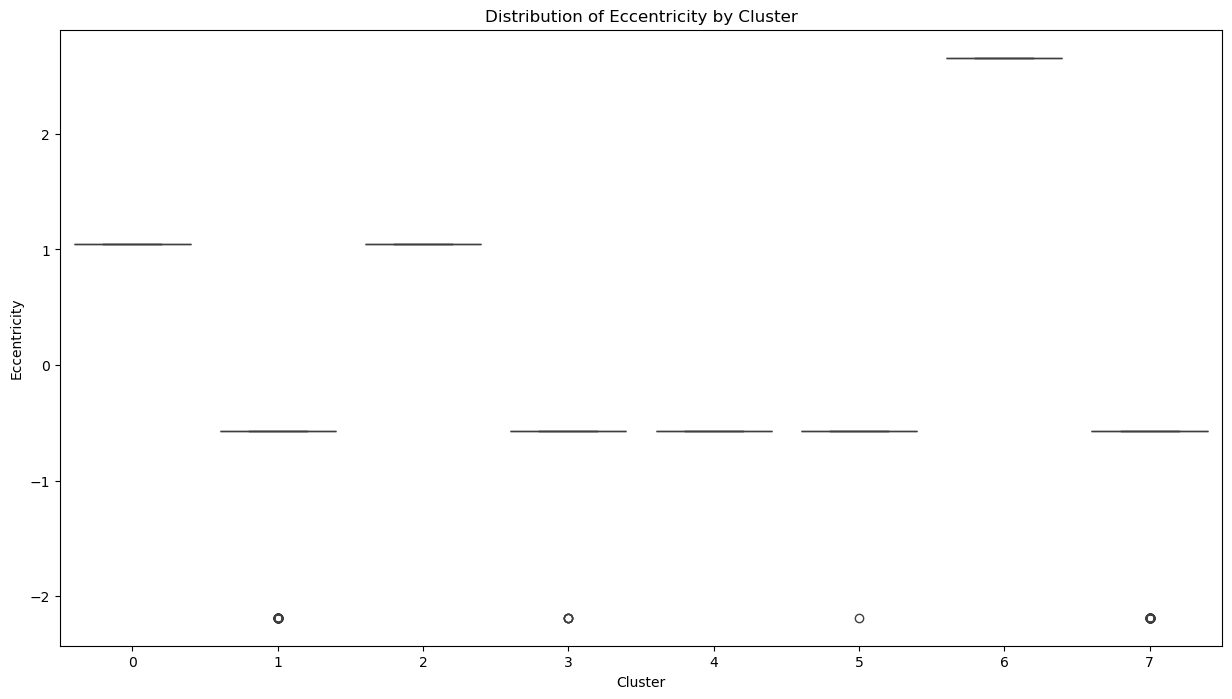

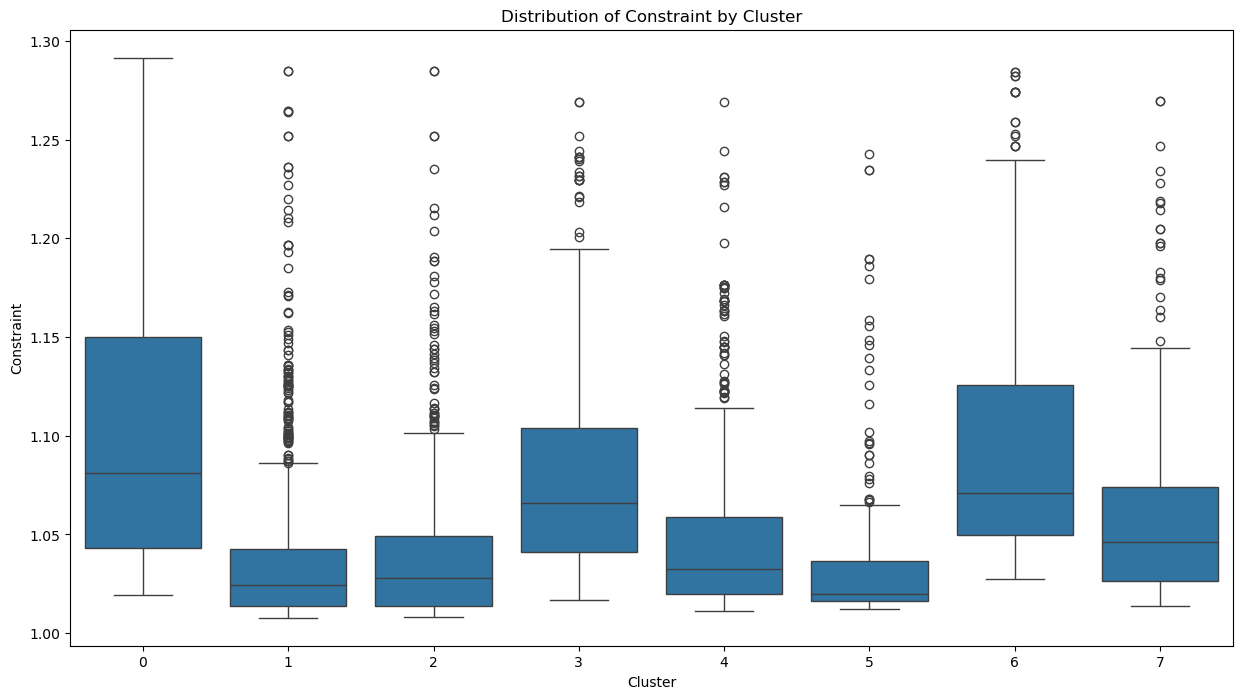

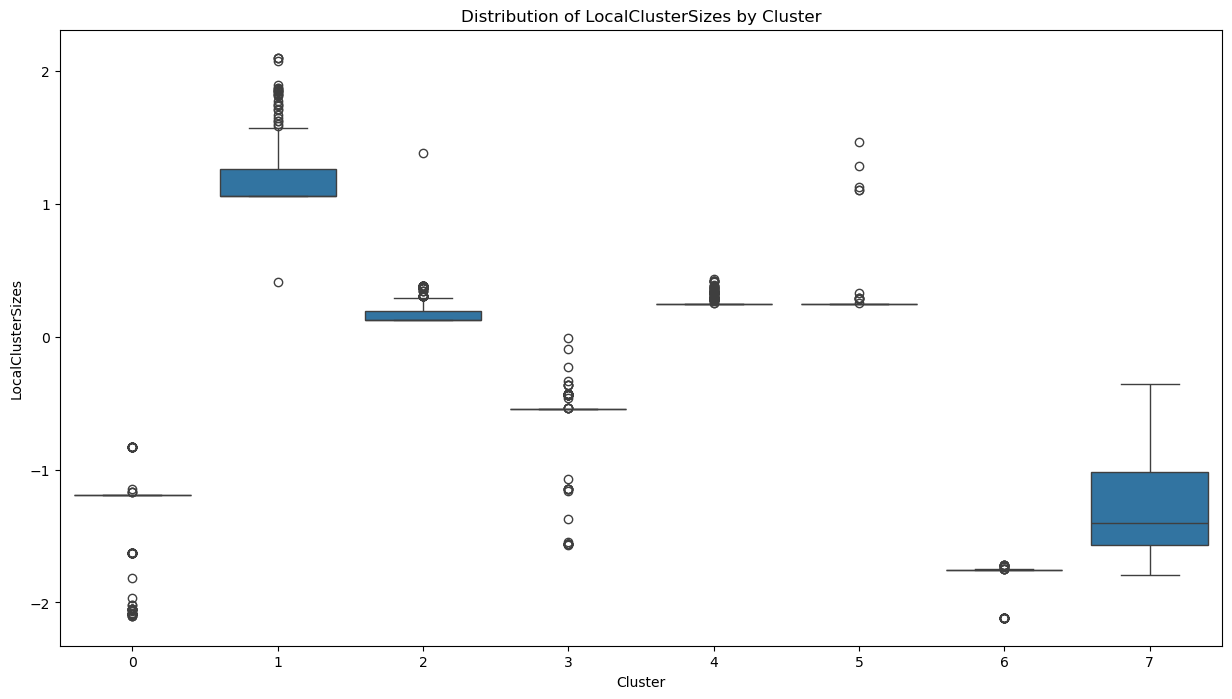

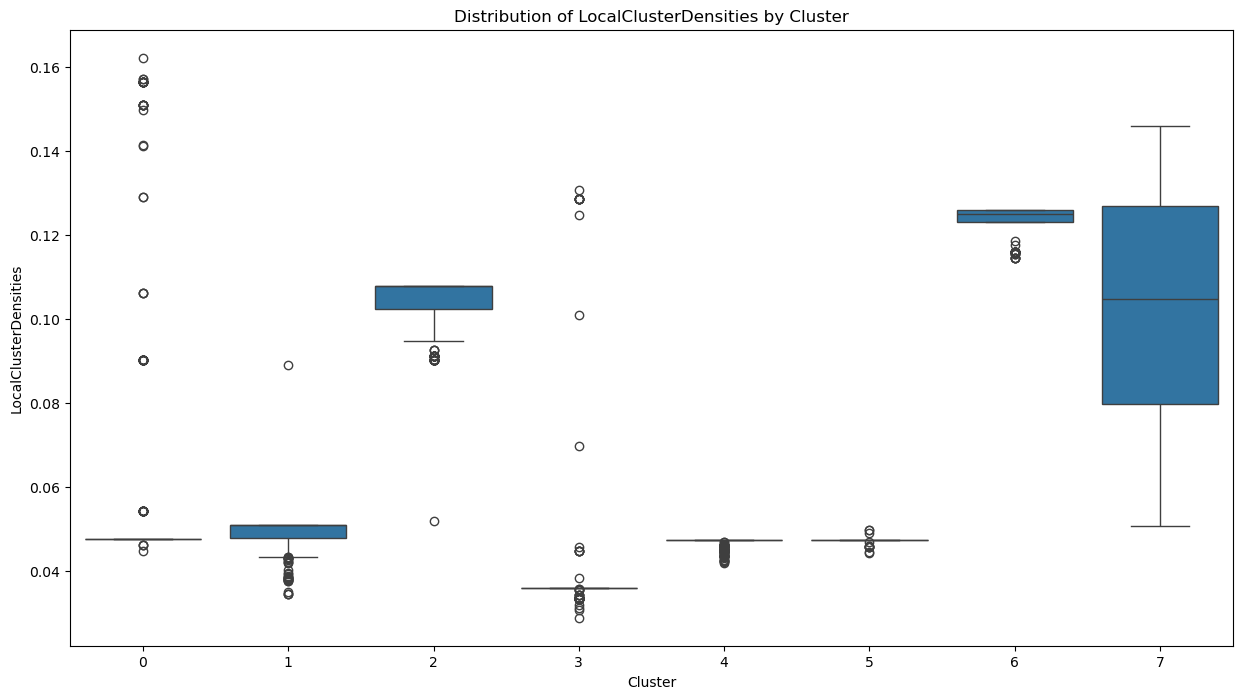

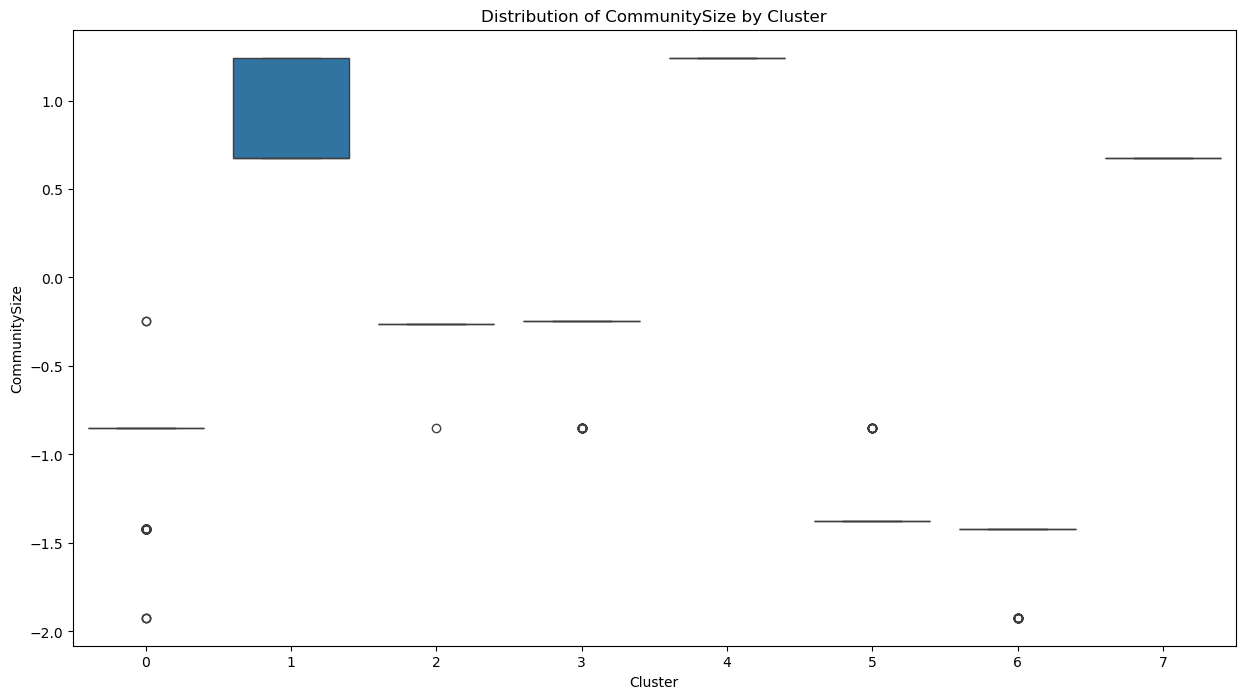

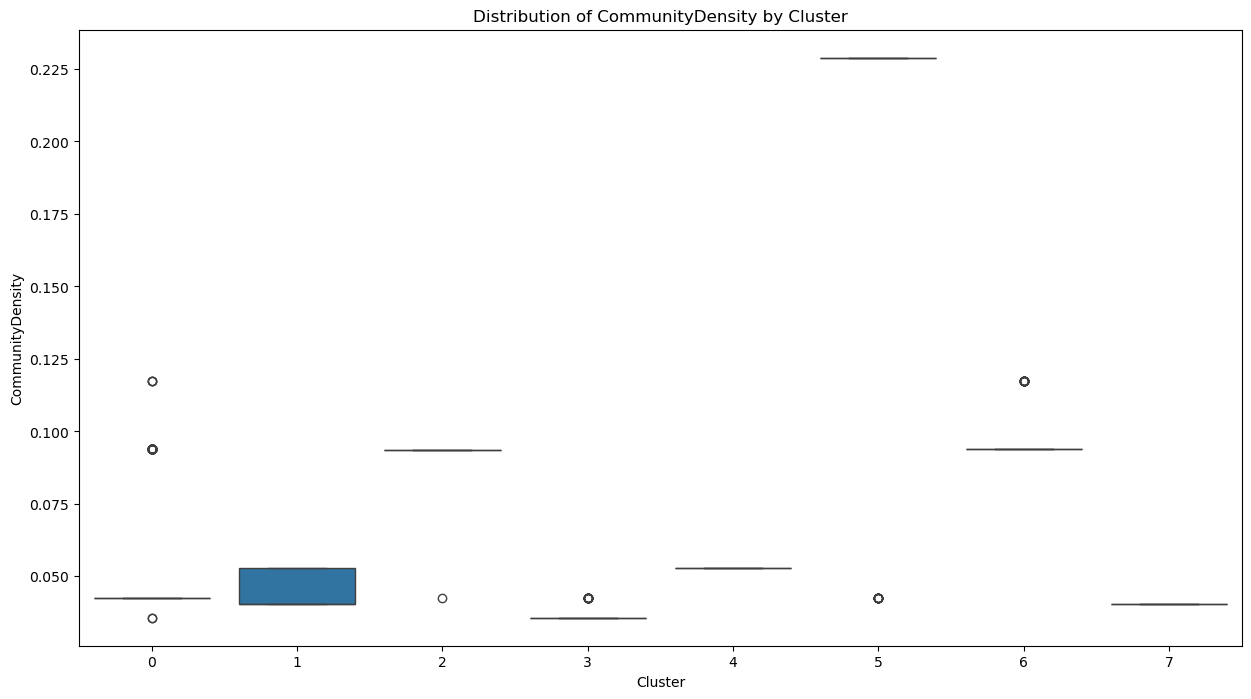

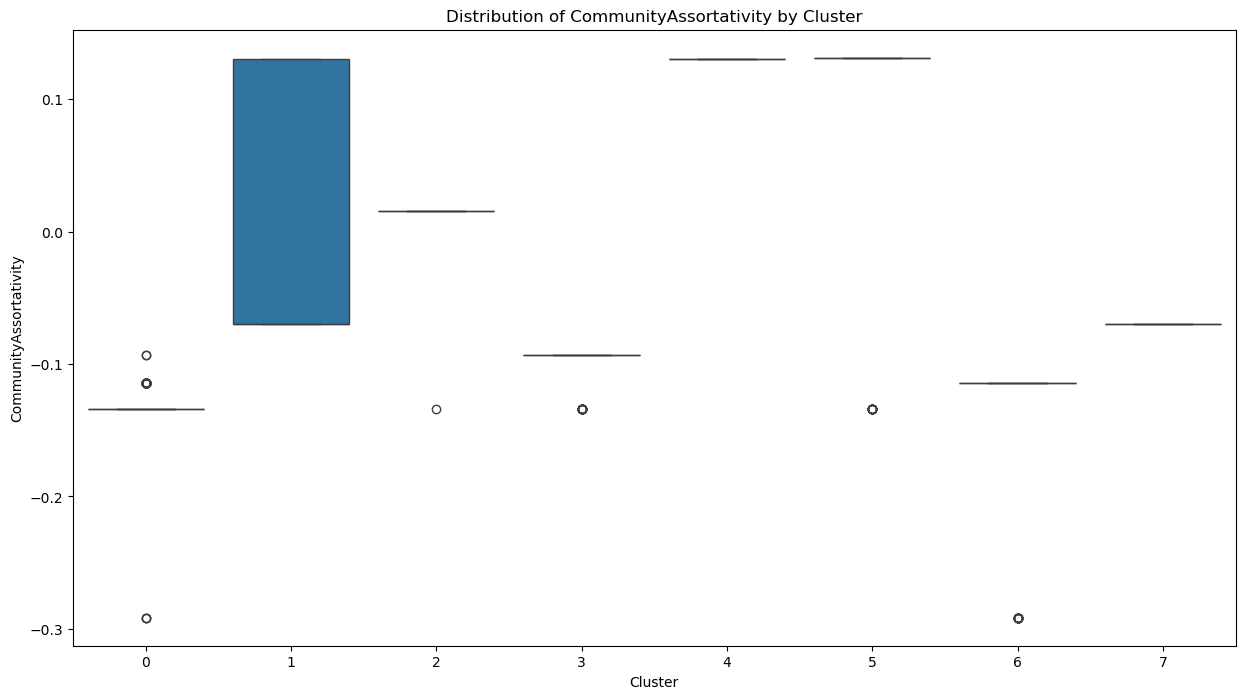

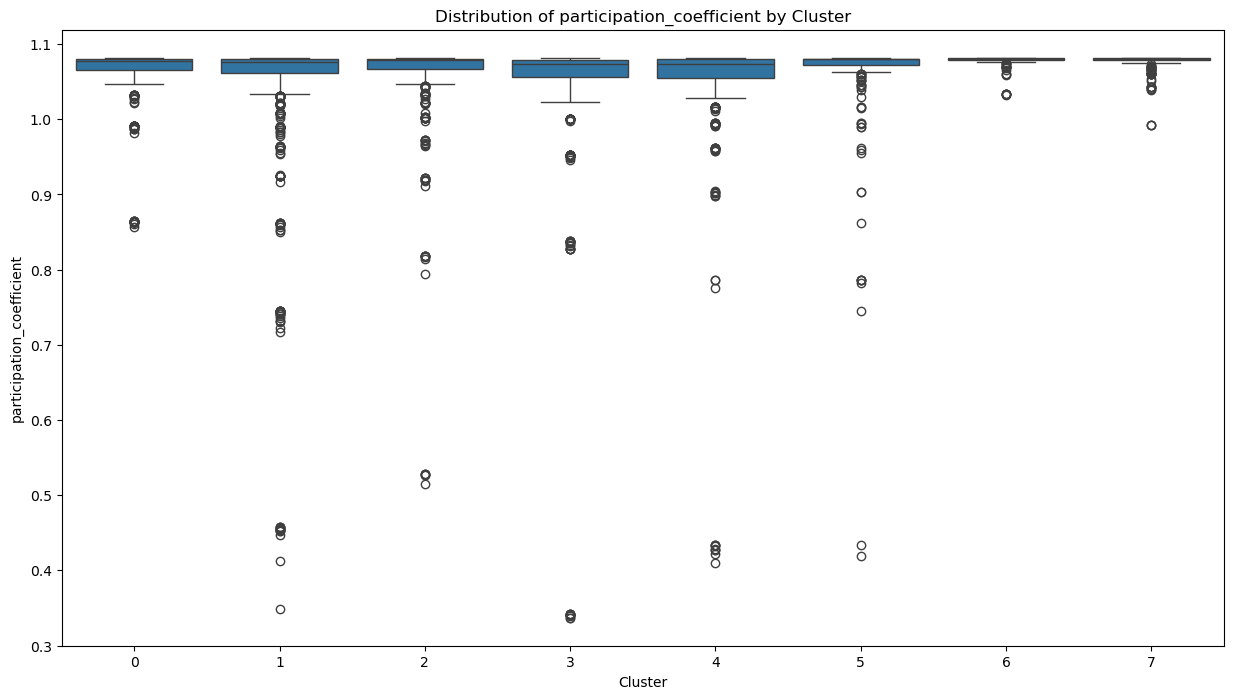

In [59]:
# Cluster Descriptions
# Cluster Sizes
cluster_sizes = pd.Series(clusters).value_counts()
print("Cluster Sizes:\n", cluster_sizes)

# Feature Distributions
# Visualize feature distributions for each cluster
features_to_visualize = ['Degree', 'ClusteringCoefficient', 'BetweennessCentrality', 'ClosenessCentrality', 'PageRank', 'MeanNeighborDegree', 'EigenvectorCentrality', 'Eccentricity', 'Constraint', 'LocalClusterSizes', 'LocalClusterDensities', 'CommunitySize', 'CommunityDensity', 'CommunityAssortativity','participation_coefficient']

for feature in features_to_visualize:
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='Cluster', y=feature, data=df_dropped)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

## Implement DBSCAN

In [60]:
X = df_dropped.drop(columns=['Node']).values
# Run DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5) 
labels = dbscan.fit_predict(X)

In [61]:
# Count number of clusters (excluding noise: label == -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Silhouette score (only if more than 1 cluster)
if n_clusters > 1:
    score = silhouette_score(X, labels)
    print(f"Silhouette Score: {score:.4f}")
else:
    print("Not enough clusters for silhouette score.")

Estimated number of clusters: 8
Estimated number of noise points: 0
Silhouette Score: 0.0551


In [62]:
# Try Multiple eps and min_samples Values (Grid Search)

best_score = -1
best_eps = None
best_min_samples = None

for eps in np.arange(0.3, 1.1, 0.1):
    for min_samples in [3, 5, 10]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Best DBSCAN Params -> eps: {best_eps}, min_samples: {best_min_samples}, Silhouette Score: {best_score:.4f}")

Best DBSCAN Params -> eps: 1.0000000000000002, min_samples: 5, Silhouette Score: 0.7530


## Visualize Clusters (PCA)

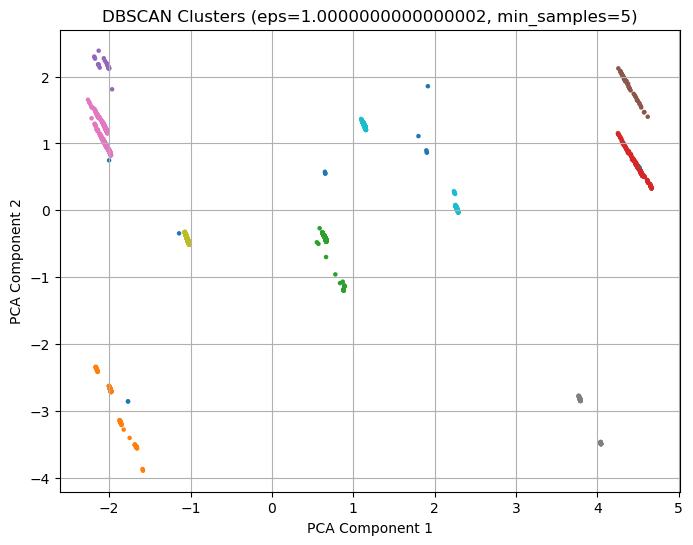

In [65]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=10)
plt.title(f"DBSCAN Clusters (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

| **Parameter**         | **What it does**                                 | **Your Setting**              |
|-----------------------|--------------------------------------------------|-------------------------------|
| `eps`                 | Max distance between neighbors                   | `1.0`                         |
| `min_samples`         | Minimum neighbors to form a cluster              | `5`                           |
| Number of clusters    | Emerges from data density (not given by you)     | `10 colors ≈ 10 clusters`     |
| Number of samples     | Your data points (4039 Facebook nodes)           | Fixed                         |

## Hierarchical Agglomerative Clustering with Grid Search

In [68]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np


X = df_dropped.drop(columns=['Node']).values

best_score = -1
best_k = None
best_linkage = None

linkage_methods = ['ward', 'complete', 'average', 'single']
cluster_range = range(2, 11)

for linkage in linkage_methods:
    for k in cluster_range:
        if linkage == 'ward':
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        else:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric='euclidean')

        labels = model.fit_predict(X)

        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_k = k
                best_linkage = linkage

print(f"Best Parameters: k={best_k}, linkage='{best_linkage}', silhouette_score={best_score:.4f}")

Best Parameters: k=8, linkage='ward', silhouette_score=0.7868


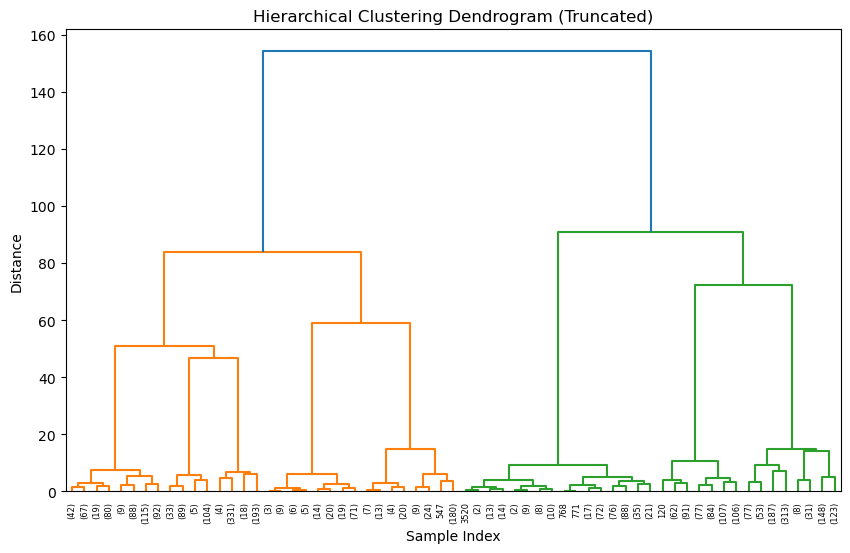

In [69]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linked = linkage(X, method=best_linkage)

plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

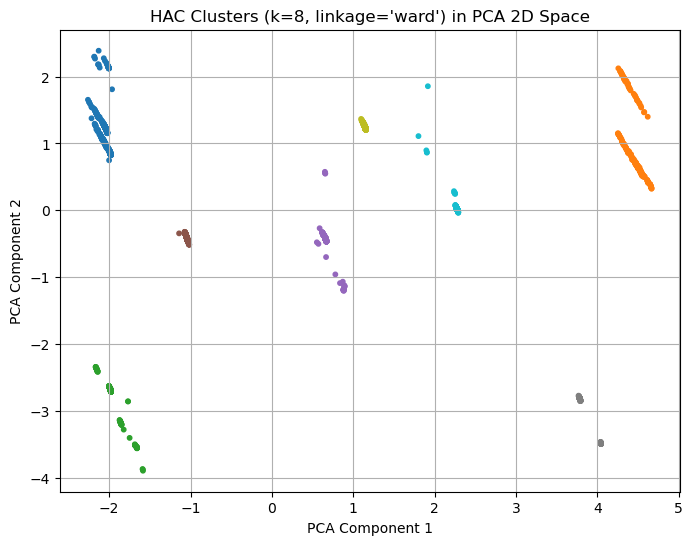

In [70]:
# Prepare data (make sure it's the same data you clustered)
X = df_dropped.drop(columns=['Node']).values

# Refit HAC model with best params
if best_linkage == 'ward':
    best_model = AgglomerativeClustering(n_clusters=best_k, linkage=best_linkage)
else:
    best_model = AgglomerativeClustering(n_clusters=best_k, linkage=best_linkage, metric='euclidean')

labels = best_model.fit_predict(X)

# Apply PCA for 2D projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=10)
plt.title(f"HAC Clusters (k={best_k}, linkage='{best_linkage}') in PCA 2D Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

| **Model**           | **Best Parameters**                 | **#Clusters** | **Silhouette Score** |
|---------------------|--------------------------------------|---------------|-----------------------|
| **K-Means**         | `n_clusters=8`, `init='k-means++'`   | 8             | ~0.625                |
| **DBSCAN**          | `eps=1.0`, `min_samples=5`           | ~10 (auto)    | 0.7530                |
| **Agglomerative**   | `n_clusters=8`, `linkage='ward'`     | 8             | **0.7868**            |

In [72]:
# Prepare features
X = df_dropped.drop(columns=['Node']).values

# Fit best HAC model
hac = AgglomerativeClustering(n_clusters=8, linkage='ward')
hac_labels = hac.fit_predict(X)

# Copy the original DataFrame and add cluster labels
df_eval = df_dropped.copy()
df_eval['Cluster'] = hac_labels

# Define function to summarize clusters
def cluster_summary(df, cluster_col='Cluster'):
    summary = df.groupby(cluster_col).agg(['mean', 'std', 'median'])
    counts = df[cluster_col].value_counts().sort_index()
    return summary, counts

# Get summary stats and cluster sizes
summary_stats, cluster_sizes = cluster_summary(df_eval)

# Display summary stats
pd.set_option('display.max_columns', None)  # Optional: show all columns
print("Summary statistics by cluster:\n")
print(summary_stats)

print("\nCluster sizes:")
print(cluster_sizes)

Summary statistics by cluster:

                Node                         Degree                      \
                mean          std  median      mean       std    median   
Cluster                                                                   
0        1380.705319   319.985655  1383.5  1.026948  0.370506  0.964147   
1         506.647287    93.852167   502.5  0.795008  0.231612  0.753048   
2         311.359459   421.412939   212.5  0.676317  0.195605  0.613428   
3        3566.478022   689.577414  3692.5  0.702006  0.171935  0.672762   
4        2275.426136   235.177647  2278.0  1.004002  0.366101  0.933993   
5        1278.190476  1181.123515   787.0  0.636258  0.135824  0.628787   
6        3069.255859   224.451632  3092.0  0.850945  0.264660  0.790138   
7        2969.138528   318.119649  2967.0  1.010179  0.296055  1.058474   

        ClusteringCoefficient                     BetweennessCentrality  \
                         mean       std    median                  

## Bussiness Case:

Social platforms often struggle to understand their user base beyond surface-level metrics. This limits:

•	Effective ad targeting

•	Personalized recommendations

•	Community health insights

Using Hierarchical Agglomerative Clustering (HAC) on a Facebook-like social network graph (4039 nodes), we grouped users based on structural and behavioral graph features (e.g., degree, clustering coefficient, closeness, eigenvector centrality, local density, etc.).

Clustering Outcome

Model Used: Agglomerative Clustering (linkage='ward', k=8)

Silhouette Score: 0.7868 (best among all models evaluated)

Result: 8 distinct, interpretable user segments

Key Cluster Insights

| **Cluster** | **Size** | **Notable Traits**                                                                 |
|-------------|---------|--------------------------------------------------------------------------------------|
| 0           | 940     | Moderate degree, high clustering, well-embedded in local communities                 |
| 1           | 258     | Lower degree, high clustering — likely tight-knit small groups                       |
| 2           | 370     | Sparse, low-degree users — possibly fringe or inactive members                       |
| 3           | 546     | Mid-core users with balanced metrics — general audience                              |
| 4           | 528     | High community density and clustering — likely community organizers                  |
| 5           | 147     | Very low eigenvector centrality — potential isolated or inactive users               |
| 6           | 512     | High closeness and participation — influencers or connectors                        |
| 7           | 231     | Small but dense, high community assortativity — niche interest groups                |


Potential Use Cases by Stakeholder,

| **Stakeholder**         | **How They Benefit**                                                                 |
|-------------------------|---------------------------------------------------------------------------------------|
| **Marketers**           | Run micro-targeted campaigns for clusters (e.g., Cluster 6 = influencers)            |
| **Product Teams**       | Roll out features to specific user cohorts (e.g., test new UI with Cluster 3)        |
| **Recommendation Engines** | Suggest groups/friends/content using intra-cluster behavior patterns               |
| **Community Managers**  | Identify isolated users (Cluster 5) or leaders (Cluster 4) to improve engagement     |
| **Researchers**         | Study behavioral topology and emergence of community dynamics                        |


Industry Fit

This analysis supports initiatives in:
	•	Digital Marketing
	•	Product Personalization
	•	Social Analytics
	•	User Retention Strategies
	•	Platform Safety & Moderation

By leveraging graph-based clustering, this project demonstrates a powerful method for data-driven user segmentation. The resulting clusters are:

Cohesive (validated by a silhouette score of 0.7868)

Actionable (interpretable by product and marketing teams)

Scalable (can be generalized across platforms)

# **Objective:**
The objective of this project is to analyze the structural properties of a social network graph using clustering techniques. This report covers the methodology, experiments, results, and insights gained from the clustering analysis of the social network graph.

# **Graph Representation:**
Social networks are complex structures with intricate relationships between nodes (users). The graph used in this analysis contains 4039 nodes and is an undirected, connected graph. A total of 28 node-level features were extracted from the graph for analysis.

# **Feature Extraction:**
Some of the important node-level features were extracted and included in the dataframe:

Degree,

Clustering Coefficient,

Betweenness Centrality,

Closeness Centrality,

PageRank,

katz_centrality,

hub_scores,

authority_scores,

Mean Neighbor Degree,

Eigenvector Centrality,

Eccentricity,

Core Number,

NumberTraingles,

Constraint,

Local Cluster Sizes,

Local Cluster Densities,

Local Cluster Assortativities,

Local efficiency,

average_degree_local_clusters,

Communities,

Community Size,

Community Density,

Community Assortativity,

Participation Coefficient,

Sorensen_indices,

adamic_adar_indices



# **Feature Engineering:**

The following steps were taken to prepare the data for clustering:

Frequency encoding is performed on the communities to convert classification data to numerical data.

Null Value Imputation: Checked for null values in the dataframe and performed mean imputation to fill any null values found in Clustering Coefficient, Number of Triangles, and Local Cluster Sizes.

**Data Normalization:** Used standard scaling to normalize the data.

**Outlier Removal:** Identified and removed outliers to ensure data quality.
The original shape of dataframe is 4039 * 28 .
If I use 2 as threshold 1071 outliers are removed and shape remains to be 2968 * 27.Removing outliers can improve model performance in some cases but might discard valuable information in others.So, wanted to consider 2.5 as threshold and remove outliers. Now shape is 3281 * 27 which is reasonable and still removed so much user information from the graph and not much difference between 2 and 2.5 threshold.Hence choosing not to remove any valuable connections or nodes information from the graph.Threshold 3 is acceptable with the shape of the dataframe as 3532 * 27 which means only 509 outliers are removed after scaling.

After performed scaling and plotting the features for visual representation , it is observed lot of right skewned and negative values in some of the features and they are applied to square root transformation to reduce
skewness.So that the model performance acn be improved.

**Correlation Analysis:** Created a heatmap to find correlated features and removed highly correlated features from the original dataframe to reduce redundancy and multicollinearity.

The final shape of the dataframe is 4039 rows and 27 columns (including the Node column).After feature engineering the final  dataframe shape is 3532 * 17

# **Clustering Analysis:**

Experiments were conducted using different clustering algorithms (KMeans, Agglomerative, and DBSCAN) to evaluate their performance using silhouette scores.

**Optimal Number of Clusters:** The optimal number of clusters (k) was determined to be 8 

| **Model**           | **Best Parameters**                 | **#Clusters** | **Silhouette Score** |
|---------------------|--------------------------------------|---------------|-----------------------|
| **K-Means**         | `n_clusters=8`, `init='k-means++'`   | 8             | ~0.625                |
| **DBSCAN**          | `eps=1.0`, `min_samples=5`           | ~10 (auto)    | 0.7530                |
| **Agglomerative**   | `n_clusters=8`, `linkage='ward'`     | 8             | **0.7868**            |


**Results Interpretation and Analysis:**

**Cluster Descriptions:**

| **Cluster** | **Size** | **Notable Traits**                                                                 |
|-------------|---------|--------------------------------------------------------------------------------------|
| 0           | 940     | Moderate degree, high clustering, well-embedded in local communities                 |
| 1           | 258     | Lower degree, high clustering — likely tight-knit small groups                       |
| 2           | 370     | Sparse, low-degree users — possibly fringe or inactive members                       |
| 3           | 546     | Mid-core users with balanced metrics — general audience                              |
| 4           | 528     | High community density and clustering — likely community organizers                  |
| 5           | 147     | Very low eigenvector centrality — potential isolated or inactive users               |
| 6           | 512     | High closeness and participation — influencers or connectors                        |
| 7           | 231     | Small but dense, high community assortativity — niche interest groups                |



**Cluster Sizes:** Displayed the number of nodes in each cluster.
Feature Distributions: Visualized feature distributions for each cluster using boxplots to understand the characteristics of each cluster.
Visualization:

Performed PCA to reduce dimensions to 2 for visualization.
Plotted the clusters to provide insights into the structure and quality of the clusters.
Silhouette Score Interpretation:

A silhouette score > 0.5 indicates well-defined and separated clusters.
The score of 0.78 suggests distinct and meaningful clusters.

# **Conclusion:**

The clustering analysis provided valuable insights into the structure of the social network. The KMeans algorithm, with an optimal k value of 8, produced well-defined clusters with a silhouette score of 0.78. The visualizations and feature distributions helped in understanding the characteristics of each cluster, guiding further refinement of the clustering approach.

# Future Work:
Further analysis could involve exploring additional clustering algorithms, incorporating more advanced feature engineering techniques, and applying the clustering insights to solve domain-specific problems such as community detection and influence analysis.

